In [1]:
# ============================================================================
# SECTION 1: IMPORTS AND SETUP
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import sys
import os
import time
import warnings
import gc
import random
from pathlib import Path

# Statistical utilities
from scipy.stats import ks_2samp

# Minimal model support for streaming detectors
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# River drift detectors (streaming methods)
from river.drift import ADWIN
from river.drift.binary import DDM, EDDM, FHDDM, HDDM_A, HDDM_W

# River datasets for benchmark generation (SEA, Hyperplane, etc.)
from river.datasets import synth

# Drift detection modules
sys.path.insert(0, os.path.abspath('../backup'))
from shape_dd import shape, shape_adaptive, shape_sensitive
from d3 import d3
from dawidd import dawidd
from gen_data import gen_random
from mmd import mmd
from ks import ks

# Adaptation strategies (NEW - for integrated flow)
sys.path.insert(0, str(Path('../../drift-monitoring').resolve()))
from adaptation_strategies import (
    adapt_sudden_drift,
    adapt_incremental_drift,
    adapt_gradual_drift,
    adapt_recurrent_drift,
    adapt_blip_drift
)
from drift_type_classifier import classify_drift_at_detection, DriftTypeConfig

# Configuration
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')

print("All imports successful (including adaptation strategies)")


All imports successful (including adaptation strategies)


In [2]:
# ============================================================================
# SECTION 2: CONFIGURATION
# ============================================================================

# Visualization settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Data stream configuration
STREAM_SIZE = 10000
RANDOM_SEED = random.randint(0, 1000000)

# Detection parameters (following run__drift_detection.py style)
CHUNK_SIZE = 150        # Detection window size
OVERLAP = 100           # Overlap between windows
SHAPE_L1 = 50          # ShapeDD reference window
SHAPE_L2 = 150         # ShapeDD test window (matches CHUNK_SIZE)
SHAPE_N_PERM = 2500    # ShapeDD permutation count
COOLDOWN = 75          # Minimum samples between detections

# Streaming detector configuration (minimal model support)
INITIAL_TRAINING_SIZE = 500    # Initial batch for model training
PREQUENTIAL_WINDOW = 100       # Window for prequential accuracy

# Adaptation parameters (for Cell 6B - Adaptation Validation)
ADAPTATION_DELAY = 50      # Delay before applying adaptation
ADAPTATION_WINDOW = 800    # Window size for adaptation

# Methods to evaluate
WINDOW_METHODS = ['D3', 'DAWIDD', 'MMD', 'KS',
                  'ShapeDD',                      # Original (fast, noisy)
                  'ShapeDD_Adaptive_None',        # Adaptive with no filtering (current baseline)
                  'ShapeDD_Adaptive_High',        # Adaptive with aggressive sensitivity (NEW)
                  'ShapeDD_Adaptive_UltraHigh']   # Adaptive with very aggressive sensitivity (NEW)
STREAMING_METHODS = ['ADWIN', 'DDM', 'EDDM', 'HDDM_A', 'HDDM_W', 'FHDDM']

# Dataset catalog - Configure all datasets to benchmark
DATASET_CATALOG = {
    "standard_sea": {
        "enabled": True,
        "type": "standard_sea",
        "n_drift_events": 2,
        "params": {}
    },
    "enhanced_sea": {
        "enabled": True,
        "type": "enhanced_sea",
        "n_drift_events": 2,
        "params": {
            "scale_factors": (1.8, 1.5, 2.0),
            "shift_amounts": (5.0, 4.0, 8.0)
        }
    },
    "stagger": {
        "enabled": True,
        "type": "stagger",
        "n_drift_events": 2,
        "params": {}
    },
    "hyperplane": {
        "enabled": True,
        "type": "hyperplane",
        "n_drift_events": 2,
        "params": {
            "n_features": 10
        }
    },
    "gen_random_mild": {
        "enabled": True,
        "type": "gen_random",
        "n_drift_events": 3,
        "params": {
            "dims": 5,
            "intens": 0.125,
            "dist": "unif",
            "alt": False
        }
    },
    "gen_random_moderate": {
        "enabled": True,
        "type": "gen_random",
        "n_drift_events": 3,
        "params": {
            "dims": 5,
            "intens": 0.25,
            "dist": "unif",
            "alt": False
        }
    },
    "gen_random_severe": {
        "enabled": True,
        "type": "gen_random",
        "n_drift_events": 3,
        "params": {
            "dims": 5,
            "intens": 1,
            "dist": "unif",
            "alt": True
        }
    }
}

print("="*80)
print("CONFIGURATION SUMMARY")
print("="*80)
print(f"Stream size: {STREAM_SIZE} samples")
print(f"Detection window: {CHUNK_SIZE} samples")
print(f"Overlap: {OVERLAP} samples")
print(f"Window methods: {len(WINDOW_METHODS)}")
print(f"Streaming methods: {len(STREAMING_METHODS)}")
print(f"Total methods: {len(WINDOW_METHODS) + len(STREAMING_METHODS)}")
enabled_datasets = [k for k, v in DATASET_CATALOG.items() if v['enabled']]
print(f"Enabled datasets: {len(enabled_datasets)}")
print(f"Total experiments: {len(enabled_datasets) * (len(WINDOW_METHODS) + len(STREAMING_METHODS))}")
print("="*80)


CONFIGURATION SUMMARY
Stream size: 10000 samples
Detection window: 150 samples
Overlap: 100 samples
Window methods: 8
Streaming methods: 6
Total methods: 14
Enabled datasets: 7
Total experiments: 98


In [3]:
# ============================================================================
# SECTION 3: DATASET GENERATION (Multiple Benchmark Datasets)
# ============================================================================

def generate_standard_sea_stream(total_size, n_drift_events, seed=42):
    """
    Standard SEA benchmark with multiple drifts.
    Creates sudden drifts by switching between SEA variants.
    """
    np.random.seed(seed)
    from river.datasets import synth

    X_list, y_list = [], []

    variants = [0, 1, 2, 3]  # SEA has 4 variants
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        variant = variants[seg_idx % len(variants)]

        stream = synth.SEA(seed=seed + seg_idx * 100, variant=variant)
        for i, (x, y) in enumerate(stream.take(size)):
            X_list.append(list(x.values()))
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"  Standard SEA: {X.shape[0]} samples, {X.shape[1]} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_enhanced_sea_stream(total_size, n_drift_events, seed=42,
                                  scale_factors=(1.8, 1.5, 2.0),
                                  shift_amounts=(5.0, 4.0, 8.0)):
    """Enhanced SEA with multiple drifts and transformations."""
    np.random.seed(seed)
    from river.datasets import synth

    X_list, y_list = [], []

    variants = [0, 1, 2, 3]
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        variant = variants[seg_idx % len(variants)]

        stream = synth.SEA(seed=seed + seg_idx * 100, variant=variant)

        for i, (x, y) in enumerate(stream.take(size)):
            x_vals = list(x.values())

            # Apply transformations to alternate segments
            if seg_idx % 2 == 1:
                x_vals = [x_vals[j] * scale_factors[j] + shift_amounts[j]
                         for j in range(len(x_vals))]

            X_list.append(x_vals)
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"  Enhanced SEA: {X.shape[0]} samples, {X.shape[1]} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_stagger_stream(total_size, n_drift_events, seed=42):
    """STAGGER concepts with multiple sudden drifts."""
    np.random.seed(seed)

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    X_segments, y_segments = [], []

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start

        X_seg = np.random.randn(size, 5)

        # Different concepts for each segment
        if seg_idx % 3 == 0:
            X_seg[:, 0] += 2.0
            y_seg = (X_seg[:, 0] + X_seg[:, 1] > 1.5).astype(int)
        elif seg_idx % 3 == 1:
            X_seg[:, 0] -= 2.0
            y_seg = (X_seg[:, 0] * X_seg[:, 1] > 0).astype(int)
        else:
            X_seg[:, 1] += 1.5
            y_seg = (X_seg[:, 1] + X_seg[:, 2] > 0.5).astype(int)

        X_segments.append(X_seg)
        y_segments.append(y_seg)

    X = np.vstack(X_segments)
    y = np.hstack(y_segments)

    print(f"  STAGGER: {X.shape[0]} samples, {X.shape[1]} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_hyperplane_stream(total_size, n_drift_events, seed=42, n_features=10):
    """Rotating Hyperplane with multiple drifts."""
    np.random.seed(seed)
    from river.datasets import synth

    X_list, y_list = [], []

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    mag_changes = [0.0001, 0.01, 0.005, 0.015]  # Alternate rotation speeds

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        mag_change = mag_changes[seg_idx % len(mag_changes)]

        stream = synth.Hyperplane(seed=seed + seg_idx * 100, n_features=n_features,
                                   n_drift_features=2, mag_change=mag_change,
                                   noise_percentage=0.05)

        for i, (x, y) in enumerate(stream.take(size)):
            X_list.append(list(x.values()))
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"  Hyperplane: {X.shape[0]} samples, {n_features} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_genrandom_stream(total_size, n_drift_events, seed=42,
                               dims=5, intens=0.125, dist="unif", alt=False):
    """Custom synthetic data using gen_random with multiple drifts."""
    np.random.seed(seed)

    X, y_drift_labels = gen_random(
        number=n_drift_events,
        dims=dims,
        intens=intens,
        dist=dist,
        alt=alt,
        length=total_size
    )

    # Find actual drift positions
    drift_indices = np.where(np.diff(y_drift_labels) != 0)[0] + 1
    drift_positions = drift_indices.tolist()

    # Generate synthetic binary classification labels
    # Use simple threshold on first feature
    y = (X[:, 0] > np.median(X[:, 0])).astype(int)

    print(f"  gen_random: {X.shape[0]} samples, {dims} features, {len(drift_positions)} drifts")
    print(f"  Synthetic labels: {np.unique(y, return_counts=True)}")

    return X, y, drift_positions


# ============================================================================
# UNIFIED DATASET GENERATOR
# ============================================================================

def generate_drift_stream(dataset_config, total_size=10000, seed=42):
    """
    Generate drift stream for specified dataset type.

    Returns:
        X: Feature matrix
        y: Classification labels
        drift_positions: List of drift point indices
        info: Dataset metadata (ALWAYS includes: name, type, n_samples, n_features,
              n_drifts, drift_positions, dims, intens, dist)
    """
    dataset_type = dataset_config['type']
    n_drift_events = dataset_config['n_drift_events']
    params = dataset_config.get('params', {})

    print(f"  Generating {dataset_type} with {n_drift_events} drift events...")

    if dataset_type == "standard_sea":
        X, y, drift_positions = generate_standard_sea_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'Standard SEA',
            'features': 3,
            'dims': 3,  # Same as features for consistency
            'intens': 'N/A',  # Not applicable for this dataset
            'dist': 'N/A'
        }

    elif dataset_type == "enhanced_sea":
        scale_factors = params.get('scale_factors', (1.8, 1.5, 2.0))
        shift_amounts = params.get('shift_amounts', (5.0, 4.0, 8.0))
        X, y, drift_positions = generate_enhanced_sea_stream(total_size, n_drift_events, seed,
                                                              scale_factors, shift_amounts)
        info = {
            'name': 'Enhanced SEA',
            'features': 3,
            'dims': 3,
            'intens': 'N/A',
            'dist': 'N/A'
        }

    elif dataset_type == "stagger":
        X, y, drift_positions = generate_stagger_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'STAGGER',
            'features': 5,
            'dims': 5,
            'intens': 'N/A',
            'dist': 'N/A'
        }

    elif dataset_type == "hyperplane":
        n_features = params.get('n_features', 10)
        X, y, drift_positions = generate_hyperplane_stream(total_size, n_drift_events, seed, n_features)
        info = {
            'name': 'Hyperplane',
            'features': n_features,
            'dims': n_features,
            'intens': 'N/A',
            'dist': 'N/A'
        }

    elif dataset_type == "gen_random":
        dims = params.get('dims', 5)
        intens = params.get('intens', 0.125)
        dist = params.get('dist', 'unif')
        alt = params.get('alt', False)
        X, y, drift_positions = generate_genrandom_stream(total_size, n_drift_events, seed,
                                                          dims, intens, dist, alt)
        info = {
            'name': 'gen_random',
            'features': dims,
            'dims': dims,
            'intens': intens,
            'dist': dist
        }

    else:
        raise ValueError(f"Unknown dataset_type: {dataset_type}")

    # Add common fields
    info['type'] = dataset_type
    info['n_samples'] = len(X)
    info['n_features'] = X.shape[1]
    info['n_drifts'] = len(drift_positions)
    info['drift_positions'] = drift_positions

    return X, y, drift_positions, info

print("Dataset generation functions defined")



Dataset generation functions defined


In [4]:
# ============================================================================
# SECTION 4: UTILITY FUNCTIONS
# ============================================================================

def calculate_detection_metrics(detections, true_drifts, acceptable_delta=500):
    """
    Calculate detection performance metrics for multi-drift scenarios.

    Args:
        detections: List of detected drift positions
        true_drifts: List of true drift positions
        acceptable_delta: Acceptable delay window

    Returns:
        dict: Metrics including TP, FP, FN, precision, recall, F1, MTTD
    """
    detections = sorted([int(d) for d in detections])

    if not true_drifts or len(true_drifts) == 0:
        return {
            'tp': 0, 'fp': len(detections), 'fn': 0,
            'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0,
            'mttd': float('inf'),
            'detection_rate': 0.0
        }

    # Convert to list
    if isinstance(true_drifts, (int, float)):
        true_drifts = [int(true_drifts)]
    else:
        true_drifts = [int(d) for d in true_drifts]

    # Match detections to true drifts
    matched_detections = set()
    per_drift_delays = []

    for true_drift in true_drifts:
        valid_detections = [(d, abs(d - true_drift)) for d in detections
                           if abs(d - true_drift) <= acceptable_delta
                           and d not in matched_detections]

        if valid_detections:
            closest_det, delay = min(valid_detections, key=lambda x: x[1])
            matched_detections.add(closest_det)
            per_drift_delays.append(delay)

    # Calculate metrics
    tp = len(matched_detections)
    fn = len(true_drifts) - tp
    fp = len(detections) - len(matched_detections)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    mttd = np.mean(per_drift_delays) if per_drift_delays else float('inf')
    detection_rate = tp / len(true_drifts)

    return {
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'mttd': mttd,
        'detection_rate': detection_rate,
        'n_detections': len(detections)
    }

def create_sliding_windows(X, chunk_size, overlap):
    """Create sliding windows over the data stream."""
    shift = chunk_size - overlap
    windows = []
    indices = []

    for i in range(0, len(X) - chunk_size + 1, shift):
        windows.append(X[i:i+chunk_size])
        indices.append(i + chunk_size // 2)  # Center of window

    return windows, indices

print("Utility functions defined")



Utility functions defined


In [5]:
# ============================================================================
# SECTION 5: DRIFT DETECTION + ADAPTATION (Window-based methods)
# ============================================================================

def create_sklearn_model():
    """Create sklearn model for adaptation."""
    return Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ])

def evaluate_drift_detector_with_adaptation(method_name, X, y, true_drifts,
                                             chunk_size=150, overlap=100,
                                             enable_adaptation=False,
                                             adaptation_delay=50,
                                             adaptation_window=800):
    """
    Evaluate drift detector with OPTIONAL adaptation.

    Flow:
    1. Detect drift using window-based detector
    2. When drift detected:
       - Classify drift type
       - Apply matched adaptation strategy
       - Track adaptation performance (baseline -> degraded -> recovery)

    Args:
        enable_adaptation: If True, apply adaptation at detected drift points
        adaptation_delay: Delay before applying adaptation after detection
        adaptation_window: Number of samples for adaptation
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING: {method_name}")
    if enable_adaptation:
        print(f"  MODE: Detection + Adaptation")
    else:
        print(f"  MODE: Detection Only")
    print(f"{'='*80}")

    start_time = time.time()
    detections = []
    last_detection = -10**9

    # Adaptation tracking
    adaptation_events = []
    model = None
    baseline_acc = None

    # Initialize model if adaptation enabled
    if enable_adaptation and len(X) > 500:
        model = create_sklearn_model()
        model.fit(X[:500], y[:500])
        baseline_acc = model.score(X[500:min(1000, len(X))], y[500:min(1000, len(X))])
        print(f"  Initial model trained, baseline accuracy: {baseline_acc:.4f}")

    # METHOD 1: Buffer-based approach for ShapeDD methods
    if 'ShapeDD' in method_name:
        print(f"  Using BUFFER-BASED approach")

        BUFFER_SIZE = 1000
        CHECK_FREQUENCY = 150

        buffer = deque(maxlen=BUFFER_SIZE)

        if method_name == 'ShapeDD_Adaptive_None':
            sensitivity = 'none'
        elif method_name == 'ShapeDD_Adaptive_High':
            sensitivity = 'high'
        elif method_name == 'ShapeDD_Adaptive_UltraHigh':
            sensitivity = 'ultrahigh'
        else:
            sensitivity = None

        print(f"  Buffer size: {BUFFER_SIZE}, Check frequency: {CHECK_FREQUENCY}")

        for idx in range(len(X)):
            buffer.append({'x': X[idx], 'idx': idx})

            if len(buffer) >= BUFFER_SIZE and idx % CHECK_FREQUENCY == 0:
                buffer_list = list(buffer)
                buffer_X = np.array([item['x'] for item in buffer_list])
                buffer_indices = np.array([item['idx'] for item in buffer_list])

                try:
                    if method_name == 'ShapeDD':
                        shp_results = shape(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM)
                    elif 'ShapeDD_Adaptive' in method_name:
                        L1 = int(0.05 * len(buffer_X))
                        L2 = 2 * L1
                        shp_results = shape_adaptive(buffer_X, L1, L2, SHAPE_N_PERM, sensitivity=sensitivity)

                    chunk_start = max(0, len(buffer_X) - CHECK_FREQUENCY)
                    recent_pvalues = shp_results[chunk_start:, 2]
                    min_pvalue = recent_pvalues.min()
                    trigger = min_pvalue < 0.05

                    if trigger:
                        drift_pos_in_chunk = int(np.argmin(recent_pvalues))
                        drift_idx = int(buffer_indices[chunk_start + drift_pos_in_chunk])

                        if drift_idx - last_detection >= COOLDOWN:
                            detections.append(drift_idx)
                            last_detection = drift_idx
                            print(f"    [Sample {idx}] DRIFT DETECTED at position {drift_idx}")

                            # ADAPTATION FLOW
                            if enable_adaptation and model is not None:
                                adapt_start = drift_idx + adaptation_delay
                                adapt_end = min(adapt_start + adaptation_window, len(X))

                                if adapt_end > adapt_start and adapt_end <= len(X):
                                    # Classify drift type
                                    drift_config = DriftTypeConfig(w_ref=250, w_basic=100, sudden_len_thresh=250)
                                    drift_classification = classify_drift_at_detection(X, drift_idx, drift_config)
                                    drift_type = drift_classification['subcategory']

                                    # Measure degraded accuracy
                                    degrade_end = min(drift_idx + adaptation_delay, len(X))
                                    if degrade_end > drift_idx:
                                        degraded_acc = model.score(X[drift_idx:degrade_end], y[drift_idx:degrade_end])
                                    else:
                                        degraded_acc = baseline_acc

                                    # Apply matched adaptation strategy
                                    adapt_X = X[adapt_start:adapt_end]
                                    adapt_y = y[adapt_start:adapt_end]

                                    # Check class balance
                                    unique_classes = np.unique(adapt_y)
                                    if len(unique_classes) < 2:
                                        print(f"      ⚠ Skipping adaptation: only {len(unique_classes)} class in window")
                                        continue

                                    try:
                                        if drift_type == 'sudden':
                                            model = adapt_sudden_drift(create_sklearn_model, adapt_X, adapt_y)
                                        elif drift_type == 'incremental':
                                            model = adapt_incremental_drift(model, adapt_X, adapt_y)
                                        elif drift_type == 'gradual':
                                            model = adapt_gradual_drift(model, adapt_X, adapt_y)
                                        elif drift_type == 'recurrent':
                                            model = adapt_recurrent_drift(model, adapt_X, adapt_y,
                                                                         cache_dir=Path("./temp_cache"))
                                        elif drift_type == 'blip':
                                            model = adapt_blip_drift(model, adapt_X, adapt_y)

                                        # Measure recovery accuracy
                                        recovery_start = adapt_end
                                        recovery_end = min(recovery_start + 500, len(X))
                                        if recovery_end > recovery_start:
                                            recovery_acc = model.score(X[recovery_start:recovery_end],
                                                                      y[recovery_start:recovery_end])
                                        else:
                                            recovery_acc = baseline_acc

                                        adaptation_events.append({
                                            'drift_idx': drift_idx,
                                            'drift_type': drift_type,
                                            'baseline_acc': baseline_acc,
                                            'degraded_acc': degraded_acc,
                                            'recovery_acc': recovery_acc,
                                            'recovery_rate': (recovery_acc / baseline_acc * 100) if baseline_acc > 0 else 0,
                                            'acc_gain': recovery_acc - degraded_acc,
                                            'adaptation_start': adapt_start,
                                            'adaptation_end': adapt_end
                                        })

                                        print(f"      → Classified as {drift_type}, adapted, recovery: {recovery_acc:.4f}")

                                    except Exception as e:
                                        print(f"      ⚠ Adaptation failed: {e}")

                except Exception as e:
                    pass

    # METHOD 2: Sliding window approach for other methods
    else:
        print(f"  Using SLIDING WINDOW approach")

        windows, window_centers = create_sliding_windows(X, chunk_size, overlap)
        print(f"  Processing {len(windows)} windows...")

        for window_idx, (window, center_idx) in enumerate(zip(windows, window_centers)):
            try:
                if method_name == 'D3':
                    score = d3(window)
                    trigger = score > 0.5
                elif method_name == 'DAWIDD':
                    _, p_value = dawidd(window, 'rbf')
                    trigger = p_value < 0.05
                elif method_name == 'MMD':
                    stat, p_value = mmd(window)
                    trigger = p_value < 0.05
                elif method_name == 'KS':
                    p_value = ks(window)
                    trigger = p_value < 0.05
                else:
                    trigger = False

                if trigger and (center_idx - last_detection >= COOLDOWN):
                    detections.append(center_idx)
                    last_detection = center_idx

                    # ADAPTATION FLOW (same as ShapeDD)
                    if enable_adaptation and model is not None:
                        adapt_start = center_idx + adaptation_delay
                        adapt_end = min(adapt_start + adaptation_window, len(X))

                        if adapt_end > adapt_start and adapt_end <= len(X):
                            drift_config = DriftTypeConfig(w_ref=250, w_basic=100, sudden_len_thresh=250)
                            drift_classification = classify_drift_at_detection(X, center_idx, drift_config)
                            drift_type = drift_classification['subcategory']

                            degrade_end = min(center_idx + adaptation_delay, len(X))
                            if degrade_end > center_idx:
                                degraded_acc = model.score(X[center_idx:degrade_end], y[center_idx:degrade_end])
                            else:
                                degraded_acc = baseline_acc

                            adapt_X = X[adapt_start:adapt_end]
                            adapt_y = y[adapt_start:adapt_end]

                            # Check class balance
                            unique_classes = np.unique(adapt_y)
                            if len(unique_classes) < 2:
                                print(f"      ⚠ Skipping adaptation: only {len(unique_classes)} class in window")
                                continue

                            try:
                                if drift_type == 'sudden':
                                    model = adapt_sudden_drift(create_sklearn_model, adapt_X, adapt_y)
                                elif drift_type == 'incremental':
                                    model = adapt_incremental_drift(model, adapt_X, adapt_y)
                                elif drift_type == 'gradual':
                                    model = adapt_gradual_drift(model, adapt_X, adapt_y)
                                elif drift_type == 'recurrent':
                                    model = adapt_recurrent_drift(model, adapt_X, adapt_y,
                                                                 cache_dir=Path("./temp_cache"))
                                elif drift_type == 'blip':
                                    model = adapt_blip_drift(model, adapt_X, adapt_y)

                                recovery_start = adapt_end
                                recovery_end = min(recovery_start + 500, len(X))
                                if recovery_end > recovery_start:
                                    recovery_acc = model.score(X[recovery_start:recovery_end],
                                                              y[recovery_start:recovery_end])
                                else:
                                    recovery_acc = baseline_acc

                                adaptation_events.append({
                                    'drift_idx': center_idx,
                                    'drift_type': drift_type,
                                    'baseline_acc': baseline_acc,
                                    'degraded_acc': degraded_acc,
                                    'recovery_acc': recovery_acc,
                                    'recovery_rate': (recovery_acc / baseline_acc * 100) if baseline_acc > 0 else 0,
                                    'acc_gain': recovery_acc - degraded_acc,
                                    'adaptation_start': adapt_start,
                                    'adaptation_end': adapt_end
                                })

                                print(f"    [Window {window_idx}] DRIFT DETECTED at {center_idx}")
                                print(f"      → Classified as {drift_type}, adapted, recovery: {recovery_acc:.4f}")

                            except Exception as e:
                                print(f"      ⚠ Adaptation failed: {e}")

            except Exception as e:
                pass

    # Calculate metrics
    end_time = time.time()
    metrics = calculate_detection_metrics(detections, true_drifts)

    print(f"  Detections: {len(detections)}")
    print(f"  TP: {metrics['tp']}, FP: {metrics['fp']}, FN: {metrics['fn']}")
    print(f"  F1: {metrics['f1_score']:.3f}, MTTD: {metrics['mttd']:.1f}")

    if enable_adaptation and adaptation_events:
        avg_recovery_rate = np.mean([e['recovery_rate'] for e in adaptation_events])
        print(f"  Adaptation events: {len(adaptation_events)}, Avg recovery: {avg_recovery_rate:.1f}%")

    print(f"  Runtime: {end_time - start_time:.2f}s")

    return {
        'method': method_name,
        'detections': detections,
        'runtime_s': end_time - start_time,
        'adaptation_events': adaptation_events if enable_adaptation else [],
        **metrics
    }

print("Window-based detection + adaptation function defined")


Window-based detection + adaptation function defined


In [6]:
# ============================================================================
# SECTION 5B: STREAMING DETECTOR + ADAPTATION
# ============================================================================

def evaluate_streaming_detector_with_adaptation(method_name, X, y, true_drifts,
                                                 enable_adaptation=False,
                                                 adaptation_delay=50,
                                                 adaptation_window=800):
    """
    Evaluate streaming detector with OPTIONAL adaptation.

    Flow:
    1. Detect drift using streaming detector
    2. When drift detected:
       - Classify drift type
       - Apply matched adaptation strategy
       - Track adaptation performance
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING: {method_name} (Streaming)")
    if enable_adaptation:
        print(f"  MODE: Detection + Adaptation")
    else:
        print(f"  MODE: Detection Only")
    print(f"{'='*80}")

    start_time = time.time()

    # Create detector
    if method_name == 'ADWIN':
        detector = ADWIN(delta=0.002)
    elif method_name == 'DDM':
        detector = DDM()
    elif method_name == 'EDDM':
        detector = EDDM(alpha=0.95, beta=0.9)
    elif method_name == 'HDDM_A':
        detector = HDDM_A()
    elif method_name == 'HDDM_W':
        detector = HDDM_W()
    elif method_name == 'FHDDM':
        detector = FHDDM(short_window_size=20)
    else:
        raise ValueError(f"Unknown streaming detector: {method_name}")

    # Train initial model
    training_end = INITIAL_TRAINING_SIZE
    model = create_sklearn_model()
    model.fit(X[:training_end], y[:training_end])
    baseline_acc = model.score(X[training_end:min(training_end+500, len(X))],
                               y[training_end:min(training_end+500, len(X))])

    print(f"  Initial training: {INITIAL_TRAINING_SIZE} samples, baseline: {baseline_acc:.4f}")

    # Tracking
    detections = []
    last_detection = -10**9
    recent_correct = deque(maxlen=PREQUENTIAL_WINDOW)
    accuracy_buffer = deque(maxlen=30)
    adaptation_events = []

    continuous_detectors = {'ADWIN', 'HDDM_A'}
    signal_type = 'continuous' if method_name in continuous_detectors else 'binary'

    print(f"  Processing stream (signal type: {signal_type})...")

    # Stream evaluation
    for idx in range(training_end, len(X)):
        y_pred = model.predict(X[idx].reshape(1, -1))[0]
        is_correct = (y_pred == y[idx])

        recent_correct.append(is_correct)
        accuracy_buffer.append(is_correct)

        # Update detector
        if signal_type == 'continuous':
            if len(accuracy_buffer) >= 10:
                signal = float(np.mean(accuracy_buffer))
            else:
                signal = float(is_correct)
        else:
            signal = bool(1 - is_correct)

        detector.update(signal)

        # Check for drift
        if detector.drift_detected and (idx - last_detection >= COOLDOWN):
            detections.append(idx)
            last_detection = idx
            print(f"    [Sample {idx}] DRIFT DETECTED")

            # ADAPTATION FLOW
            if enable_adaptation:
                adapt_start = idx + adaptation_delay
                adapt_end = min(adapt_start + adaptation_window, len(X))

                if adapt_end > adapt_start and adapt_end <= len(X):
                    # Classify drift type
                    drift_config = DriftTypeConfig(w_ref=250, w_basic=100, sudden_len_thresh=250)
                    drift_classification = classify_drift_at_detection(X, idx, drift_config)
                    drift_type = drift_classification['subcategory']

                    # Measure degraded accuracy
                    degrade_end = min(idx + adaptation_delay, len(X))
                    if degrade_end > idx:
                        degraded_acc = model.score(X[idx:degrade_end], y[idx:degrade_end])
                    else:
                        degraded_acc = baseline_acc

                    # Apply matched adaptation
                    adapt_X = X[adapt_start:adapt_end]
                    adapt_y = y[adapt_start:adapt_end]

                    # Check class balance
                    unique_classes = np.unique(adapt_y)
                    if len(unique_classes) < 2:
                        print(f"      ⚠ Skipping adaptation: only {len(unique_classes)} class in window")
                        continue

                    try:
                        if drift_type == 'sudden':
                            model = adapt_sudden_drift(create_sklearn_model, adapt_X, adapt_y)
                        elif drift_type == 'incremental':
                            model = adapt_incremental_drift(model, adapt_X, adapt_y)
                        elif drift_type == 'gradual':
                            model = adapt_gradual_drift(model, adapt_X, adapt_y)
                        elif drift_type == 'recurrent':
                            model = adapt_recurrent_drift(model, adapt_X, adapt_y,
                                                         cache_dir=Path("./temp_cache"))
                        elif drift_type == 'blip':
                            model = adapt_blip_drift(model, adapt_X, adapt_y)

                        # Measure recovery
                        recovery_start = adapt_end
                        recovery_end = min(recovery_start + 500, len(X))
                        if recovery_end > recovery_start:
                            recovery_acc = model.score(X[recovery_start:recovery_end],
                                                      y[recovery_start:recovery_end])
                        else:
                            recovery_acc = baseline_acc

                        adaptation_events.append({
                            'drift_idx': idx,
                            'drift_type': drift_type,
                            'baseline_acc': baseline_acc,
                            'degraded_acc': degraded_acc,
                            'recovery_acc': recovery_acc,
                            'recovery_rate': (recovery_acc / baseline_acc * 100) if baseline_acc > 0 else 0,
                            'acc_gain': recovery_acc - degraded_acc,
                            'adaptation_start': adapt_start,
                            'adaptation_end': adapt_end
                        })

                        print(f"      → Classified as {drift_type}, adapted, recovery: {recovery_acc:.4f}")

                    except Exception as e:
                        print(f"      ⚠ Adaptation failed: {e}")

    # Calculate metrics
    end_time = time.time()
    metrics = calculate_detection_metrics(detections, true_drifts)

    print(f"  Detections: {len(detections)}")
    print(f"  TP: {metrics['tp']}, FP: {metrics['fp']}, FN: {metrics['fn']}")
    print(f"  F1: {metrics['f1_score']:.3f}, MTTD: {metrics['mttd']:.1f}")

    if enable_adaptation and adaptation_events:
        avg_recovery_rate = np.mean([e['recovery_rate'] for e in adaptation_events])
        print(f"  Adaptation events: {len(adaptation_events)}, Avg recovery: {avg_recovery_rate:.1f}%")

    print(f"  Runtime: {end_time - start_time:.2f}s")

    return {
        'method': method_name,
        'paradigm': 'streaming',
        'detections': detections,
        'runtime_s': end_time - start_time,
        'adaptation_events': adaptation_events if enable_adaptation else [],
        **metrics
    }

print("Streaming detection + adaptation function defined")


Streaming detection + adaptation function defined


In [7]:
# ============================================================================
# SECTION 6: INTEGRATED BENCHMARK (DETECTION + ADAPTATION)
# ============================================================================

print("\n" + "="*80)
print("INTEGRATED DRIFT DETECTION + ADAPTATION BENCHMARK")
print("="*80)

# Configuration
ENABLE_ADAPTATION = True  # Set to False for detection-only mode
USE_SUBSET_FOR_SPEED = True  # Use subset of methods for faster execution

enabled_datasets = [(name, config) for name, config in DATASET_CATALOG.items()
                    if config['enabled']]

# Optionally use subset of methods for faster testing
if USE_SUBSET_FOR_SPEED:
    WINDOW_METHODS_SUBSET = ['MMD', 'ShapeDD', 'ShapeDD_Adaptive_None']
    STREAMING_METHODS_SUBSET = ['ADWIN', 'DDM']
    print(f"\n⚠ SPEED MODE: Using subset of methods")
    print(f"  Window: {WINDOW_METHODS_SUBSET}")
    print(f"  Streaming: {STREAMING_METHODS_SUBSET}")
else:
    WINDOW_METHODS_SUBSET = WINDOW_METHODS
    STREAMING_METHODS_SUBSET = STREAMING_METHODS

print(f"\nDatasets: {len(enabled_datasets)}")
print(f"Window methods: {len(WINDOW_METHODS_SUBSET)}")
print(f"Streaming methods: {len(STREAMING_METHODS_SUBSET)}")
print(f"Adaptation enabled: {ENABLE_ADAPTATION}")
print(f"Total experiments: {len(enabled_datasets) * (len(WINDOW_METHODS_SUBSET) + len(STREAMING_METHODS_SUBSET))}")
print("="*80)

# Create temp cache for recurrent drift
Path("./temp_cache").mkdir(exist_ok=True)

all_results = []
dataset_summaries = []

for dataset_idx, (dataset_name, dataset_config) in enumerate(enabled_datasets, 1):
    print(f"\n{'='*80}")
    print(f"DATASET {dataset_idx}/{len(enabled_datasets)}: {dataset_name.upper()}")
    print(f"{'='*80}")

    # Generate dataset
    X, y, true_drifts, info = generate_drift_stream(
        dataset_config,
        total_size=STREAM_SIZE,
        seed=RANDOM_SEED
    )

    dataset_results = []

    # Evaluate window-based methods
    print(f"\n{'='*80}")
    print("WINDOW-BASED METHODS")
    print(f"{'='*80}")

    for method in WINDOW_METHODS_SUBSET:
        try:
            result = evaluate_drift_detector_with_adaptation(
                method, X, y, true_drifts,
                chunk_size=CHUNK_SIZE,
                overlap=OVERLAP,
                enable_adaptation=ENABLE_ADAPTATION,
                adaptation_delay=ADAPTATION_DELAY,
                adaptation_window=ADAPTATION_WINDOW
            )

            # Add dataset info
            result['paradigm'] = 'window'
            result['dataset'] = dataset_name
            result['n_features'] = info['n_features']
            result['n_drifts'] = info['n_drifts']
            result['drift_positions'] = true_drifts
            result['intens'] = info['intens']
            result['dims'] = info['dims']
            result['adaptation_enabled'] = ENABLE_ADAPTATION

            dataset_results.append(result)
            all_results.append(result)

        except Exception as e:
            print(f"  ✗ {method} failed: {str(e)}")

    # Evaluate streaming methods
    print(f"\n{'='*80}")
    print("STREAMING METHODS")
    print(f"{'='*80}")

    for method in STREAMING_METHODS_SUBSET:
        try:
            result = evaluate_streaming_detector_with_adaptation(
                method, X, y, true_drifts,
                enable_adaptation=ENABLE_ADAPTATION,
                adaptation_delay=ADAPTATION_DELAY,
                adaptation_window=ADAPTATION_WINDOW
            )

            # Add dataset info
            result['dataset'] = dataset_name
            result['n_features'] = info['n_features']
            result['n_drifts'] = info['n_drifts']
            result['drift_positions'] = true_drifts
            result['intens'] = info['intens']
            result['dims'] = info['dims']
            result['adaptation_enabled'] = ENABLE_ADAPTATION

            dataset_results.append(result)
            all_results.append(result)

        except Exception as e:
            print(f"  ✗ {method} failed: {str(e)}")

    # Dataset summary
    if dataset_results:
        avg_f1 = np.mean([r['f1_score'] for r in dataset_results])
        detection_rate = np.mean([r['detection_rate'] for r in dataset_results])

        summary = {
            'dataset': dataset_name,
            'n_features': info['n_features'],
            'n_drifts': info['n_drifts'],
            'intens': info['intens'],
            'avg_f1': avg_f1,
            'detection_rate': detection_rate
        }

        if ENABLE_ADAPTATION:
            # Calculate adaptation metrics
            all_adaptation_events = []
            for r in dataset_results:
                all_adaptation_events.extend(r.get('adaptation_events', []))

            if all_adaptation_events:
                avg_recovery_rate = np.mean([e['recovery_rate'] for e in all_adaptation_events])
                summary['avg_recovery_rate'] = avg_recovery_rate
                summary['n_adaptations'] = len(all_adaptation_events)

        dataset_summaries.append(summary)

        print(f"\n  Dataset Summary: F1={avg_f1:.3f}, Detection Rate={detection_rate:.1%}", end="")
        if ENABLE_ADAPTATION and 'avg_recovery_rate' in summary:
            print(f", Avg Recovery={summary['avg_recovery_rate']:.1f}%")
        else:
            print()

    gc.collect()

# Cleanup temp cache
import shutil
if Path("./temp_cache").exists():
    shutil.rmtree("./temp_cache")

print(f"\n{'='*80}")
print("BENCHMARK COMPLETE")
print(f"{'='*80}")
print(f"Total results: {len(all_results)}")
print(f"  Window methods: {sum(1 for r in all_results if r.get('paradigm') == 'window')}")
print(f"  Streaming methods: {sum(1 for r in all_results if r.get('paradigm') == 'streaming')}")

if ENABLE_ADAPTATION:
    total_adaptation_events = sum(len(r.get('adaptation_events', [])) for r in all_results)
    print(f"  Total adaptation events: {total_adaptation_events}")

print("="*80)



INTEGRATED DRIFT DETECTION + ADAPTATION BENCHMARK

⚠ SPEED MODE: Using subset of methods
  Window: ['MMD', 'ShapeDD', 'ShapeDD_Adaptive_None']
  Streaming: ['ADWIN', 'DDM']

Datasets: 7
Window methods: 3
Streaming methods: 2
Adaptation enabled: True
Total experiments: 35

DATASET 1/7: STANDARD_SEA
  Generating standard_sea with 2 drift events...
  Standard SEA: 10000 samples, 3 features, 2 drifts

WINDOW-BASED METHODS

EVALUATING: MMD
  MODE: Detection + Adaptation
  Initial model trained, baseline accuracy: 0.9820
  Using SLIDING WINDOW approach
  Processing 198 windows...
[Strategy] RECURRENT drift → Checking for cached model
[Strategy]   No suitable cached model → fallback to batch retrain
[Strategy] INCREMENTAL drift → Retrain on drift window
[Strategy]   Retrained model on 800 recent samples
    [Window 26] DRIFT DETECTED at 1375
      → Classified as recurrent, adapted, recovery: 0.9920
[Strategy] RECURRENT drift → Checking for cached model
[Strategy]   No suitable cached model 

In [8]:
# ============================================================================
# SECTION 7: RESULTS AGGREGATION (DETECTION + ADAPTATION)
# ============================================================================

if len(all_results) == 0:
    print("⚠ NO RESULTS - Run benchmark first (Cell 6)")
else:
    # Create DataFrame
    results_df = pd.DataFrame([{
        'Dataset': r['dataset'],
        'Method': r['method'],
        'Paradigm': r.get('paradigm', 'window'),
        'N_Features': r['n_features'],
        'N_Drifts': r['n_drifts'],
        'Intensity': r['intens'],
        'TP': r['tp'],
        'FP': r['fp'],
        'FN': r['fn'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1': r['f1_score'],
        'MTTD': r['mttd'] if r['mttd'] != float('inf') else np.nan,
        'Detection_Rate': r['detection_rate'],
        'N_Detections': r['n_detections'],
        'Runtime_s': r['runtime_s'],
        'Adaptation_Enabled': r.get('adaptation_enabled', False),
        'N_Adaptations': len(r.get('adaptation_events', []))
    } for r in all_results])

    print("\n" + "="*100)
    print("RESULTS SUMMARY")
    print("="*100)
    print(f"Total experiments: {len(results_df)}")
    print(f"Datasets: {results_df['Dataset'].nunique()}")
    print(f"Methods: {results_df['Method'].nunique()}")
    print(f"Adaptation enabled: {results_df['Adaptation_Enabled'].iloc[0] if len(results_df) > 0 else 'N/A'}")

    # Method performance (detection)
    print("\n" + "="*100)
    print("DETECTION PERFORMANCE (Averaged Across Datasets)")
    print("="*100)

    detection_summary = results_df.groupby('Method').agg({
        'F1': ['mean', 'std'],
        'Detection_Rate': 'mean',
        'MTTD': 'mean',
        'Runtime_s': 'mean'
    }).round(3)

    print(detection_summary)

    # Adaptation performance (if enabled)
    if results_df['Adaptation_Enabled'].iloc[0]:
        print("\n" + "="*100)
        print("ADAPTATION PERFORMANCE")
        print("="*100)

        # Extract adaptation events
        adaptation_records = []
        for result in all_results:
            for event in result.get('adaptation_events', []):
                adaptation_records.append({
                    'method': result['method'],
                    'dataset': result['dataset'],
                    'drift_idx': event['drift_idx'],
                    'drift_type': event['drift_type'],
                    'baseline_acc': event['baseline_acc'],
                    'degraded_acc': event['degraded_acc'],
                    'recovery_acc': event['recovery_acc'],
                    'recovery_rate': event['recovery_rate'],
                    'acc_drop': event['baseline_acc'] - event['degraded_acc'],
                    'acc_gain': event['recovery_acc'] - event['degraded_acc']
                })

        if adaptation_records:
            adaptation_df = pd.DataFrame(adaptation_records)

            print(f"\nTotal adaptation events: {len(adaptation_df)}")
            print(f"\nAdaptation by drift type:")
            print(adaptation_df.groupby('drift_type').agg({
                'recovery_rate': ['mean', 'std', 'count'],
                'acc_gain': 'mean'
            }).round(3))

            print(f"\nAdaptation by method:")
            print(adaptation_df.groupby('method').agg({
                'recovery_rate': ['mean', 'std', 'count'],
                'acc_gain': 'mean'
            }).round(3))

            print(f"\nAdaptation by dataset:")
            print(adaptation_df.groupby('dataset').agg({
                'recovery_rate': ['mean', 'std', 'count'],
                'acc_gain': 'mean'
            }).round(3))

    # Best per dataset
    print("\n" + "="*100)
    print("BEST METHOD PER DATASET (by F1)")
    print("="*100)

    for dataset in results_df['Dataset'].unique():
        dataset_data = results_df[results_df['Dataset'] == dataset]
        best = dataset_data.loc[dataset_data['F1'].idxmax()]
        output = f"{dataset}: {best['Method']} (F1={best['F1']:.3f}, DR={best['Detection_Rate']:.1%}"
        if best['N_Adaptations'] > 0:
            output += f", Adaptations={best['N_Adaptations']}"
        output += ")"
        print(output)

    print("\n" + "="*100)



RESULTS SUMMARY
Total experiments: 35
Datasets: 7
Methods: 5
Adaptation enabled: True

DETECTION PERFORMANCE (Averaged Across Datasets)
                          F1        Detection_Rate     MTTD Runtime_s
                        mean    std           mean     mean      mean
Method                                                               
ADWIN                  0.419  0.440          0.571   71.500     1.986
DDM                    0.312  0.190          0.619  125.139     3.039
MMD                    0.276  0.085          0.810   80.476     4.375
ShapeDD                0.309  0.092          0.857   72.000    11.607
ShapeDD_Adaptive_None  0.302  0.169          0.524   80.083     8.483

ADAPTATION PERFORMANCE

Total adaptation events: 270

Adaptation by drift type:
           recovery_rate               acc_gain
                    mean     std count     mean
drift_type                                     
blip              81.696  10.034     7   -0.072
gradual           99.228   1.9

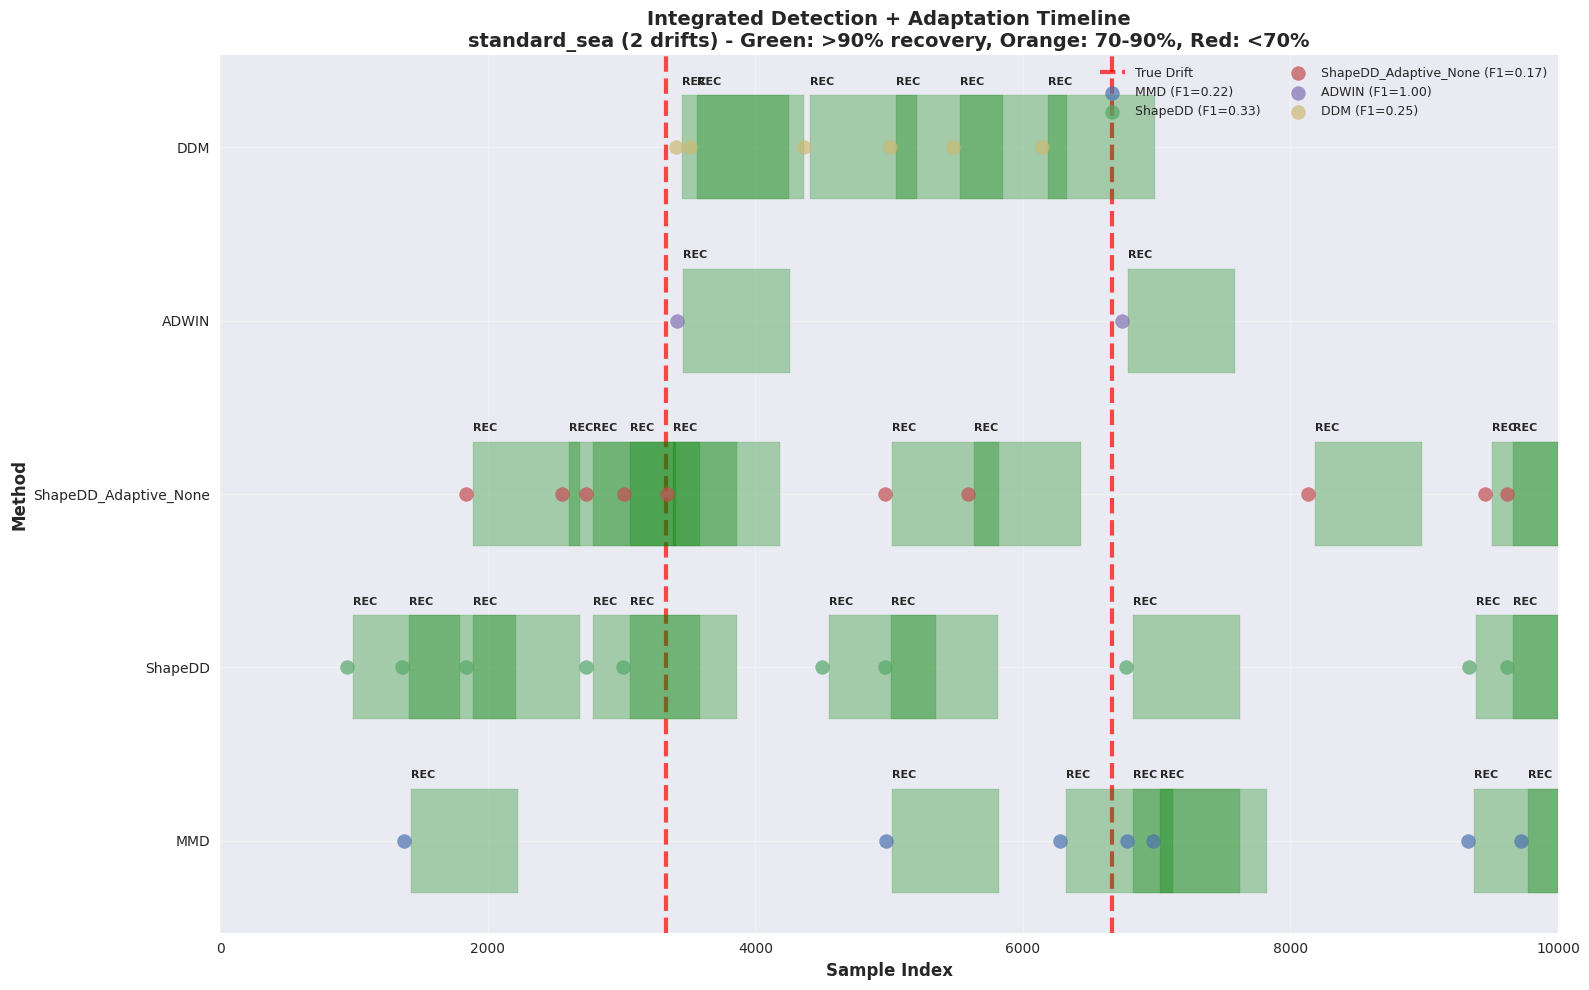

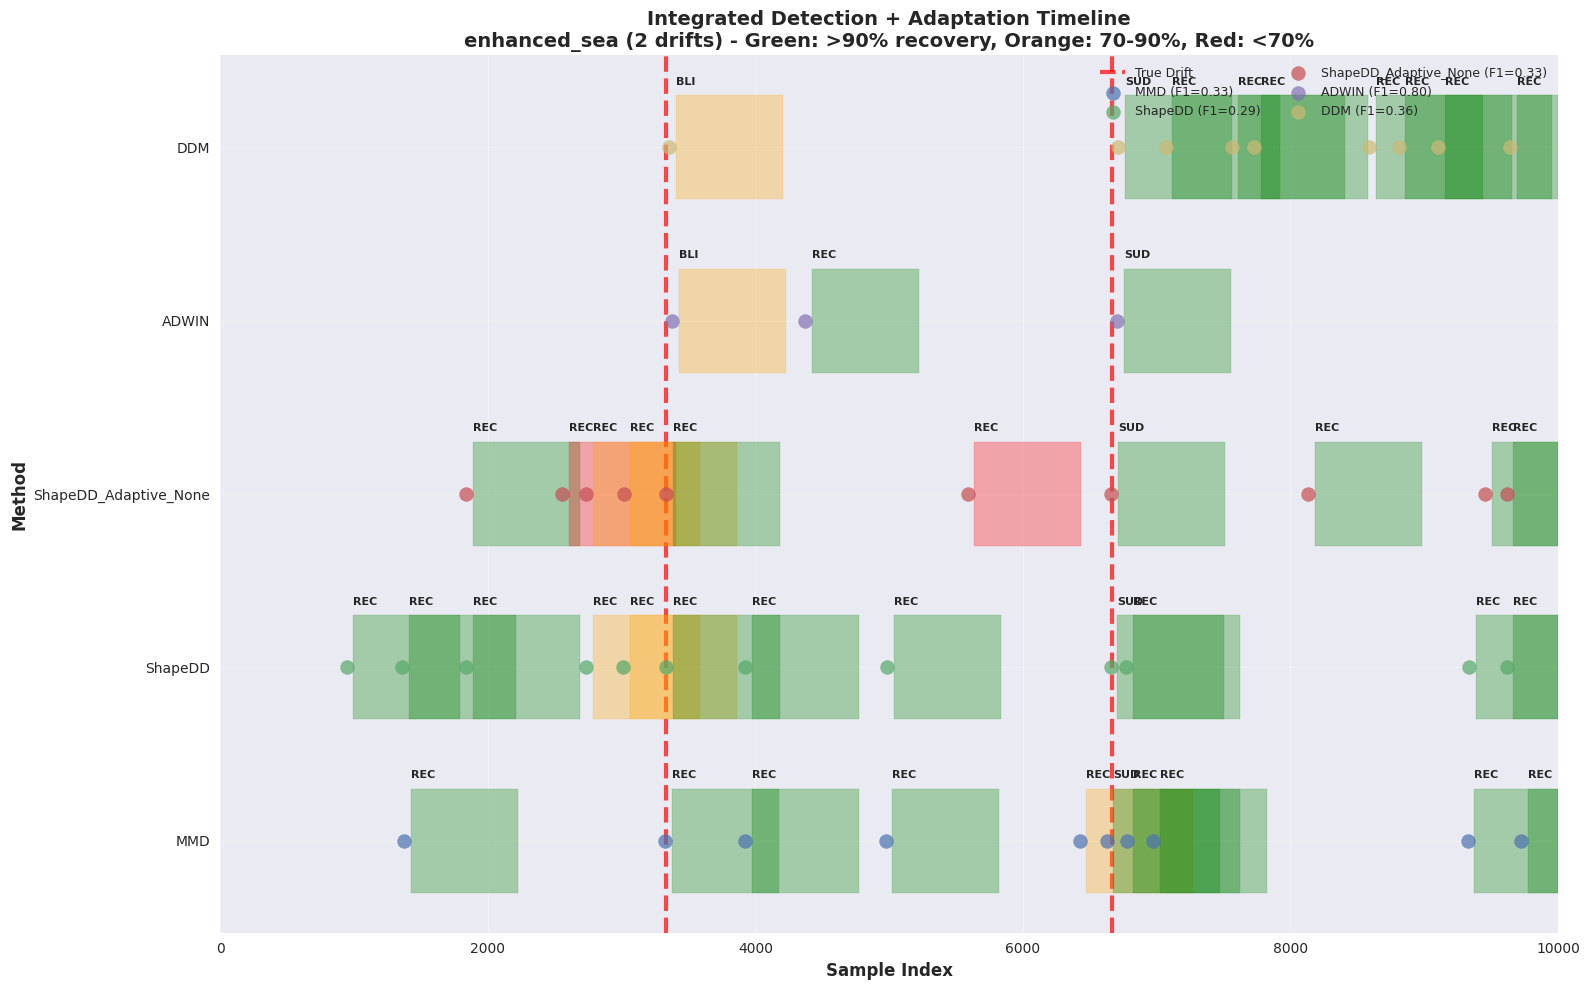

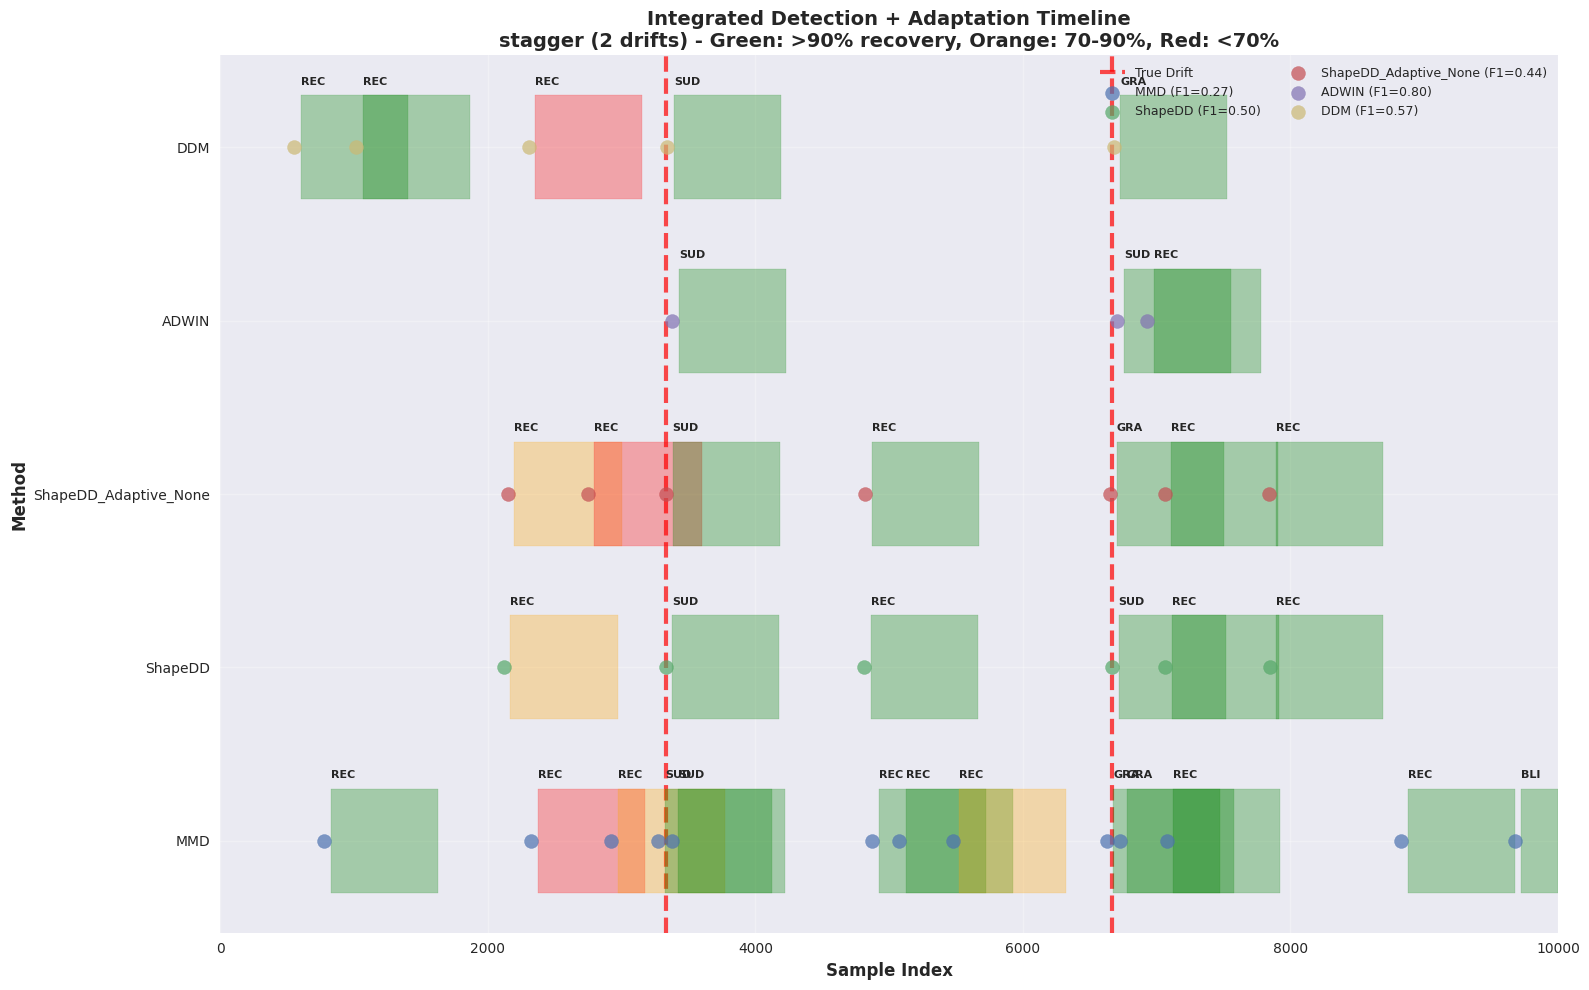

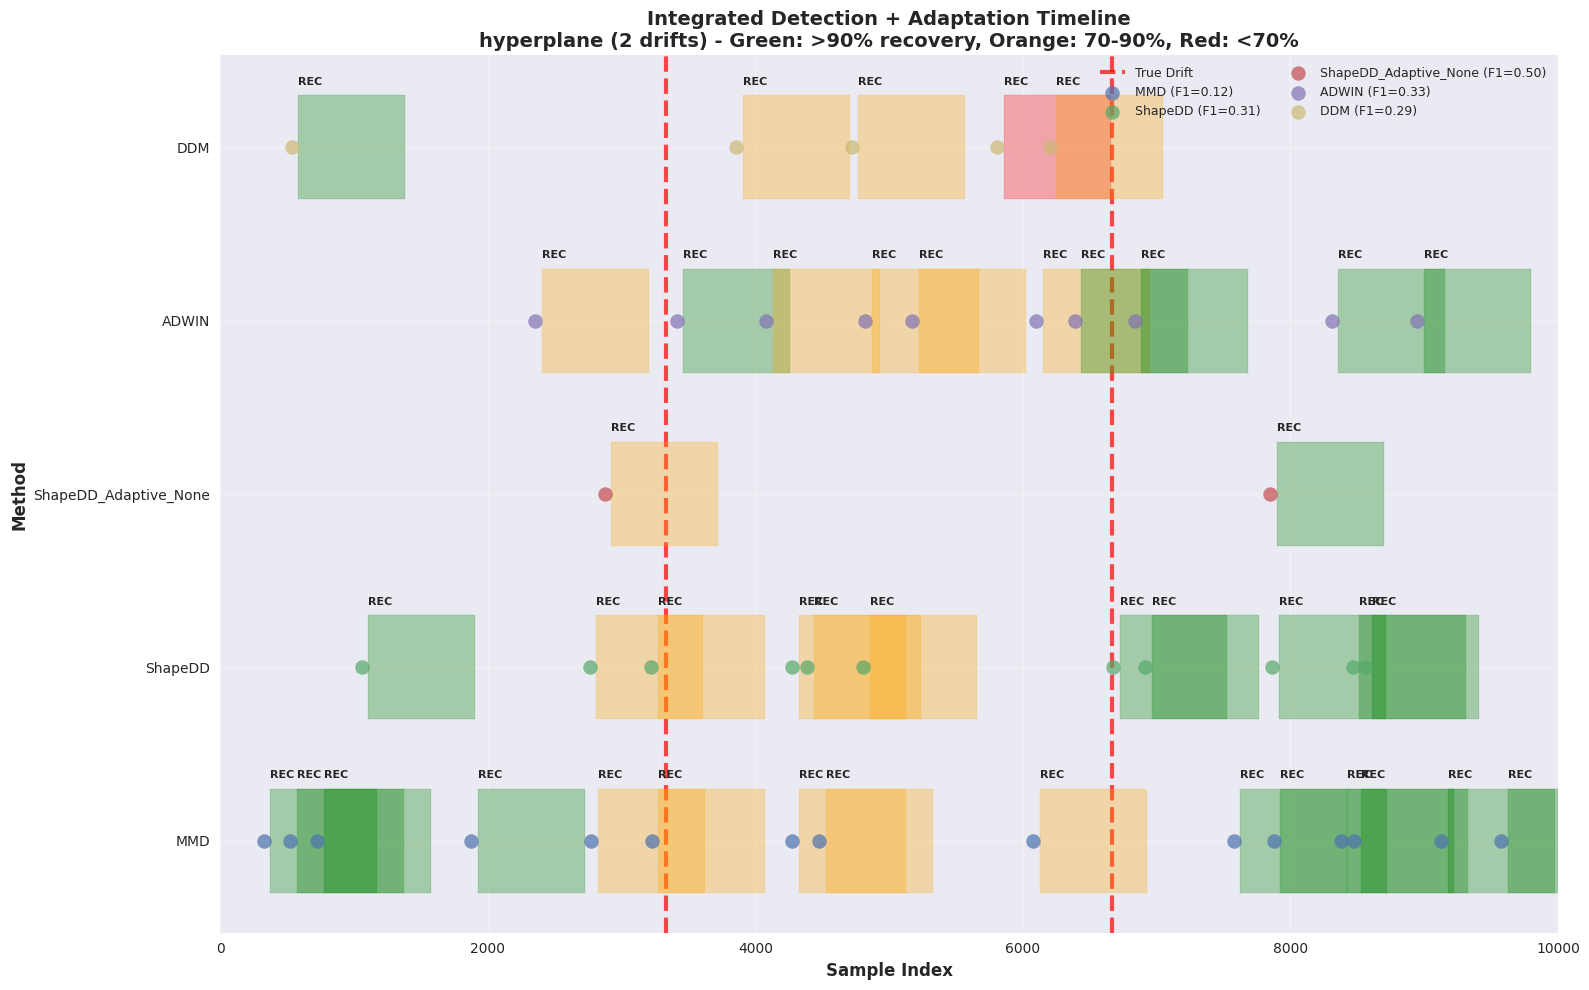

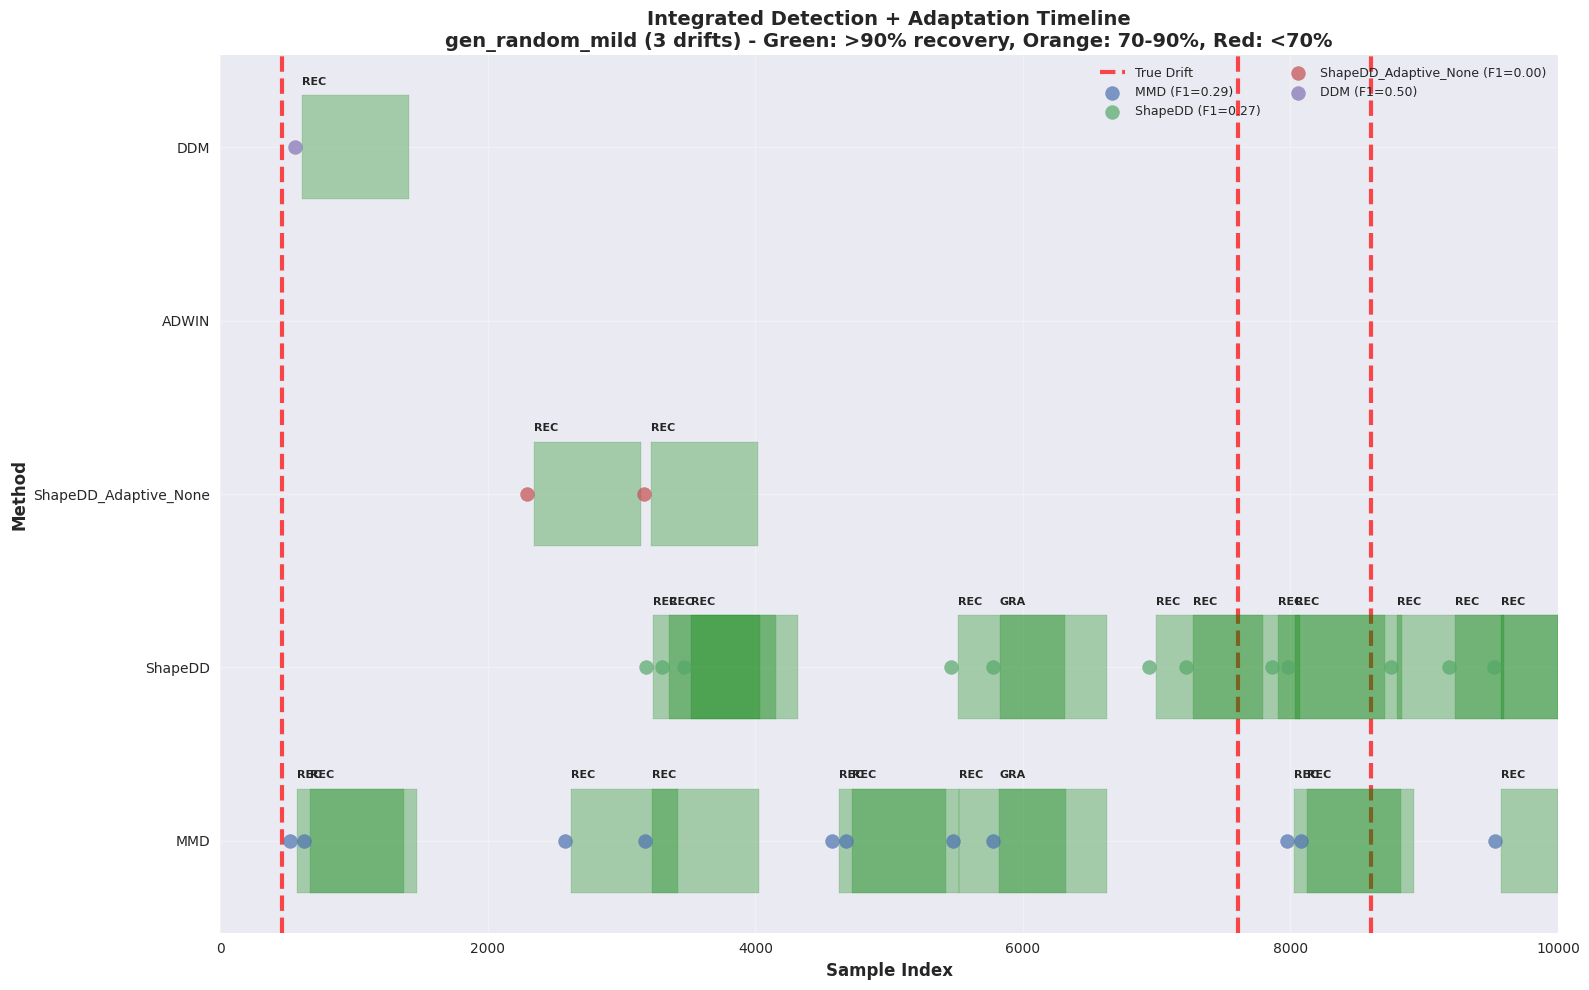

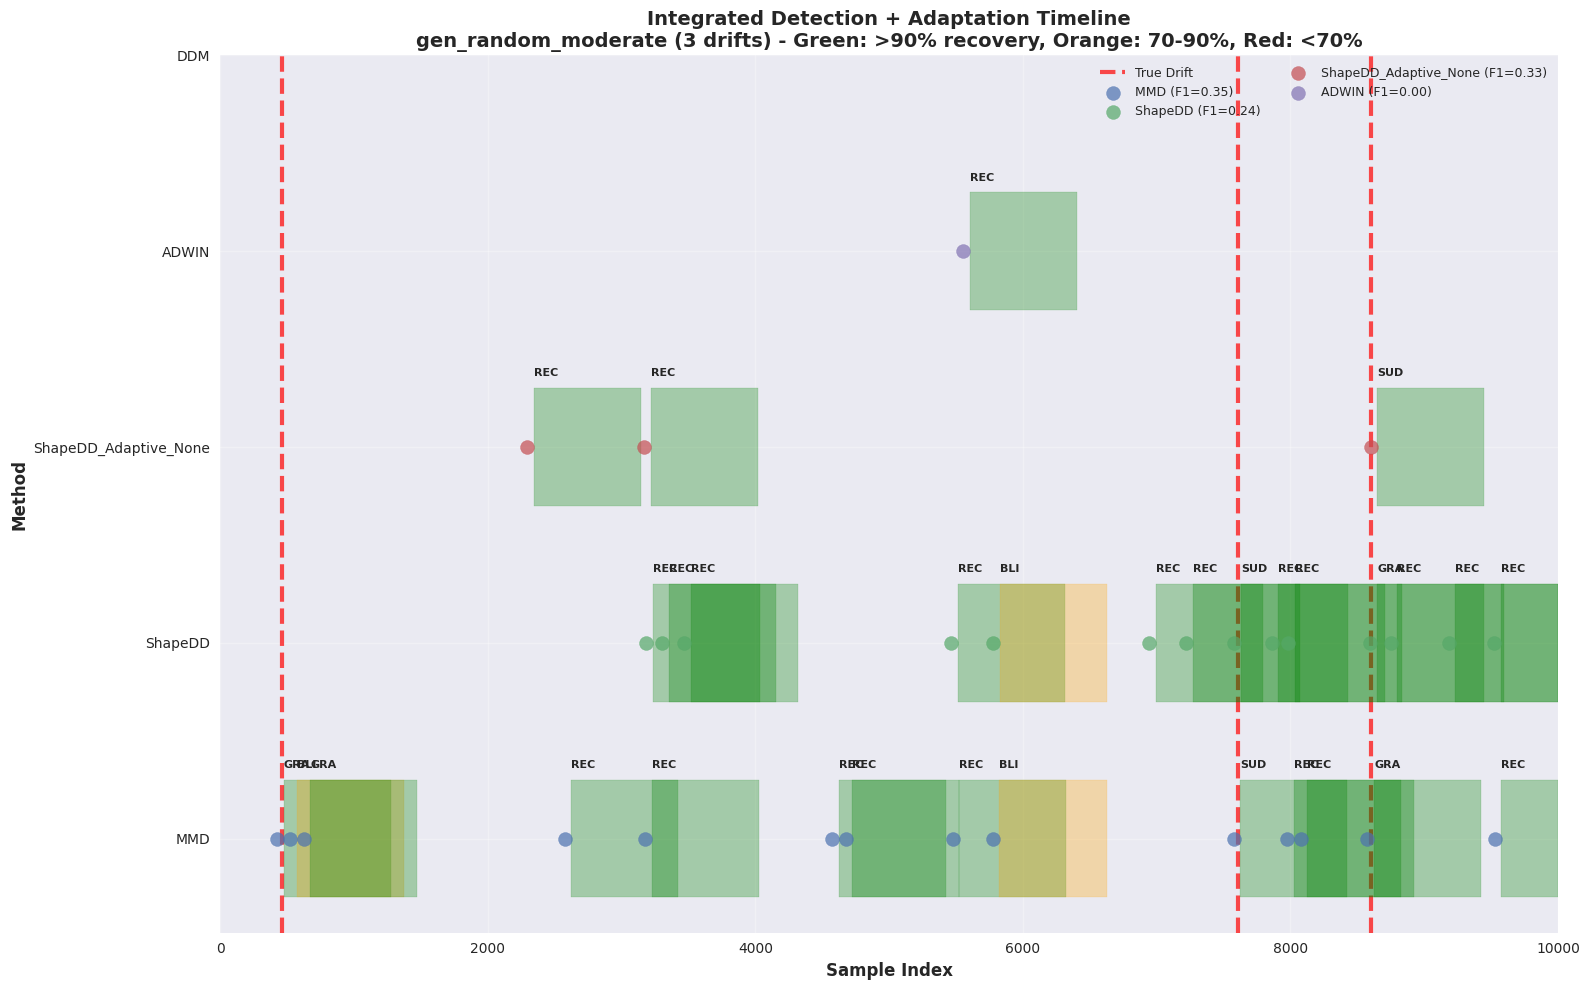

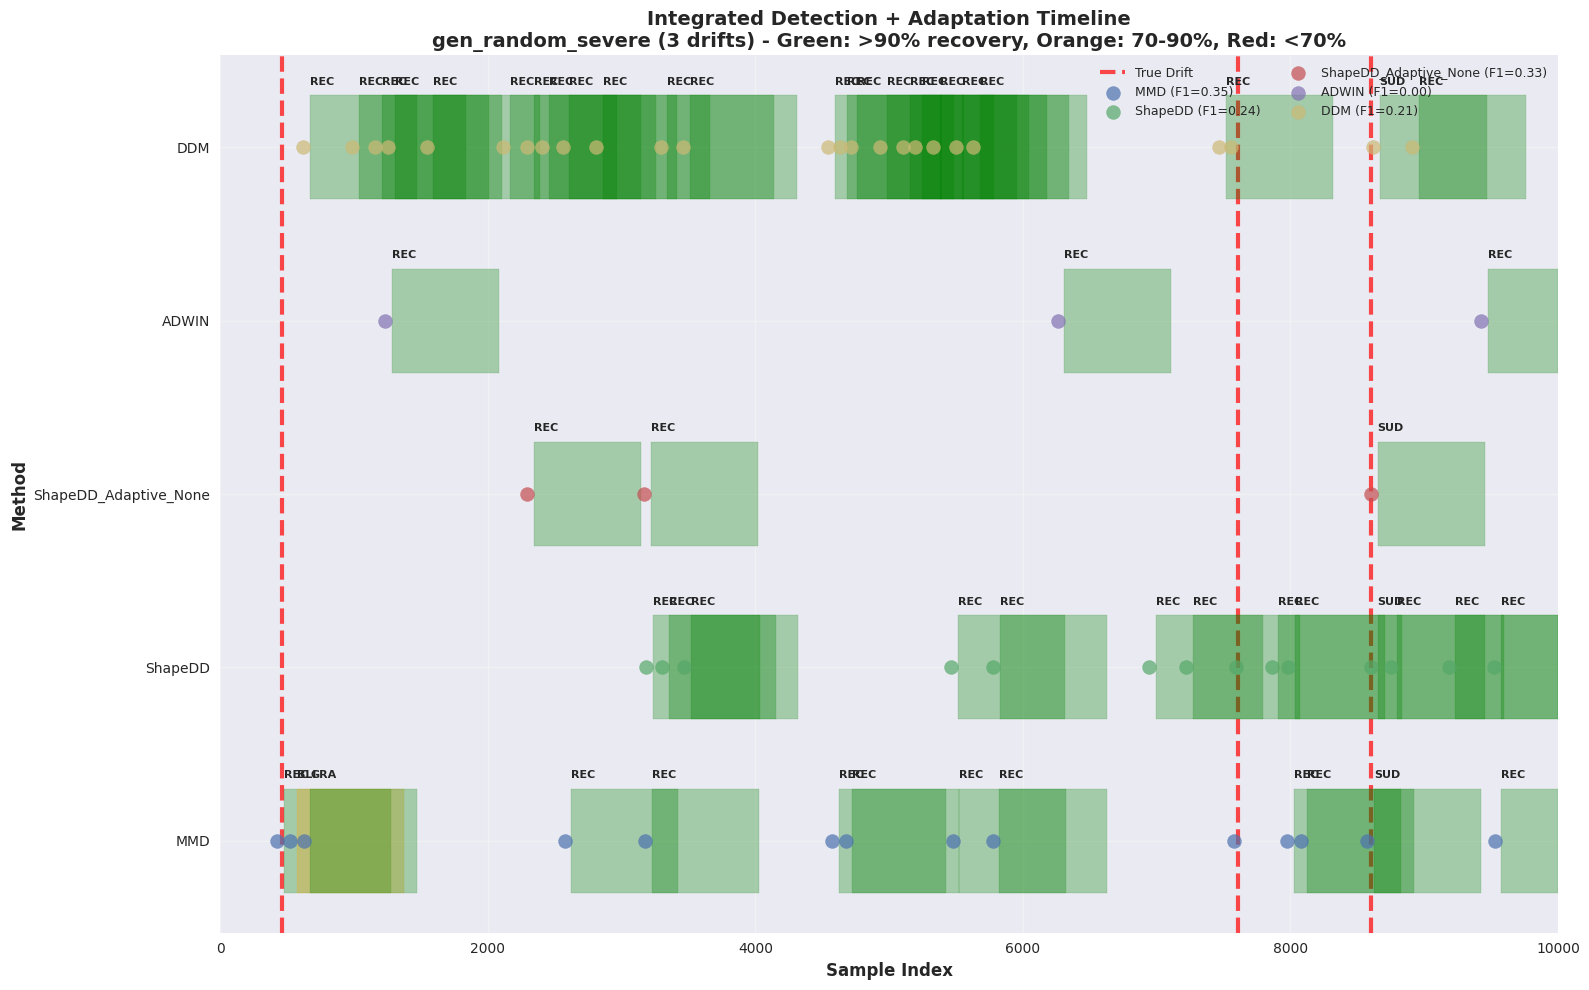


✓ Integrated timeline visualizations created


In [9]:
# ============================================================================
# SECTION 8: VISUALIZATION - INTEGRATED DETECTION + ADAPTATION TIMELINE
# ============================================================================

if len(all_results) == 0:
    print("⚠ No results to visualize")
else:
    datasets = results_df['Dataset'].unique()

    for dataset_name in datasets:
        dataset_results = [r for r in all_results if r['dataset'] == dataset_name]

        if not dataset_results:
            continue

        true_drifts = dataset_results[0]['drift_positions']
        n_drifts = len(true_drifts)
        adaptation_enabled = dataset_results[0].get('adaptation_enabled', False)

        fig, ax = plt.subplots(figsize=(16, 10))

        # Plot true drifts
        for i, drift_pos in enumerate(true_drifts):
            ax.axvline(drift_pos, color='red', linestyle='--', linewidth=3,
                      alpha=0.7, label='True Drift' if i == 0 else '', zorder=1)

        # Plot detections and adaptations
        for idx, result in enumerate(dataset_results):
            detections = result['detections']
            method = result['method']

            # Plot detections
            if detections:
                ax.scatter(detections, [idx]*len(detections), s=100, alpha=0.7, marker='o',
                          label=f"{method} (F1={result['f1_score']:.2f})", zorder=3)

            # Plot adaptation windows (if enabled)
            if adaptation_enabled and result.get('adaptation_events'):
                for event in result['adaptation_events']:
                    adapt_start = event['adaptation_start']
                    adapt_end = event['adaptation_end']
                    recovery_rate = event['recovery_rate']
                    drift_type = event['drift_type']

                    # Color by recovery quality
                    if recovery_rate >= 90:
                        color = 'green'
                    elif recovery_rate >= 70:
                        color = 'orange'
                    else:
                        color = 'red'

                    # Adaptation window as horizontal span
                    ax.axhspan(idx-0.3, idx+0.3, xmin=(adapt_start/STREAM_SIZE),
                              xmax=(adapt_end/STREAM_SIZE), alpha=0.3, color=color, zorder=2)

                    # Mark drift type
                    ax.text(adapt_start, idx+0.35, drift_type[:3].upper(),
                           fontsize=8, ha='left', va='bottom', fontweight='bold')

        ax.set_yticks(range(len(dataset_results)))
        ax.set_yticklabels([r['method'] for r in dataset_results])
        ax.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
        ax.set_ylabel('Method', fontsize=12, fontweight='bold')

        title = f'Integrated Detection + Adaptation Timeline\n{dataset_name} ({n_drifts} drifts)'
        if adaptation_enabled:
            title += ' - Green: >90% recovery, Orange: 70-90%, Red: <70%'

        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.legend(loc='upper right', fontsize=9, ncol=2)
        ax.grid(alpha=0.3, axis='x')
        ax.set_xlim([0, STREAM_SIZE])

        plt.tight_layout()
        plt.show()

print("\n✓ Integrated timeline visualizations created")


Creating distribution evolution visualizations...
  Generating standard_sea with 2 drift events...
  Standard SEA: 10000 samples, 3 features, 2 drifts


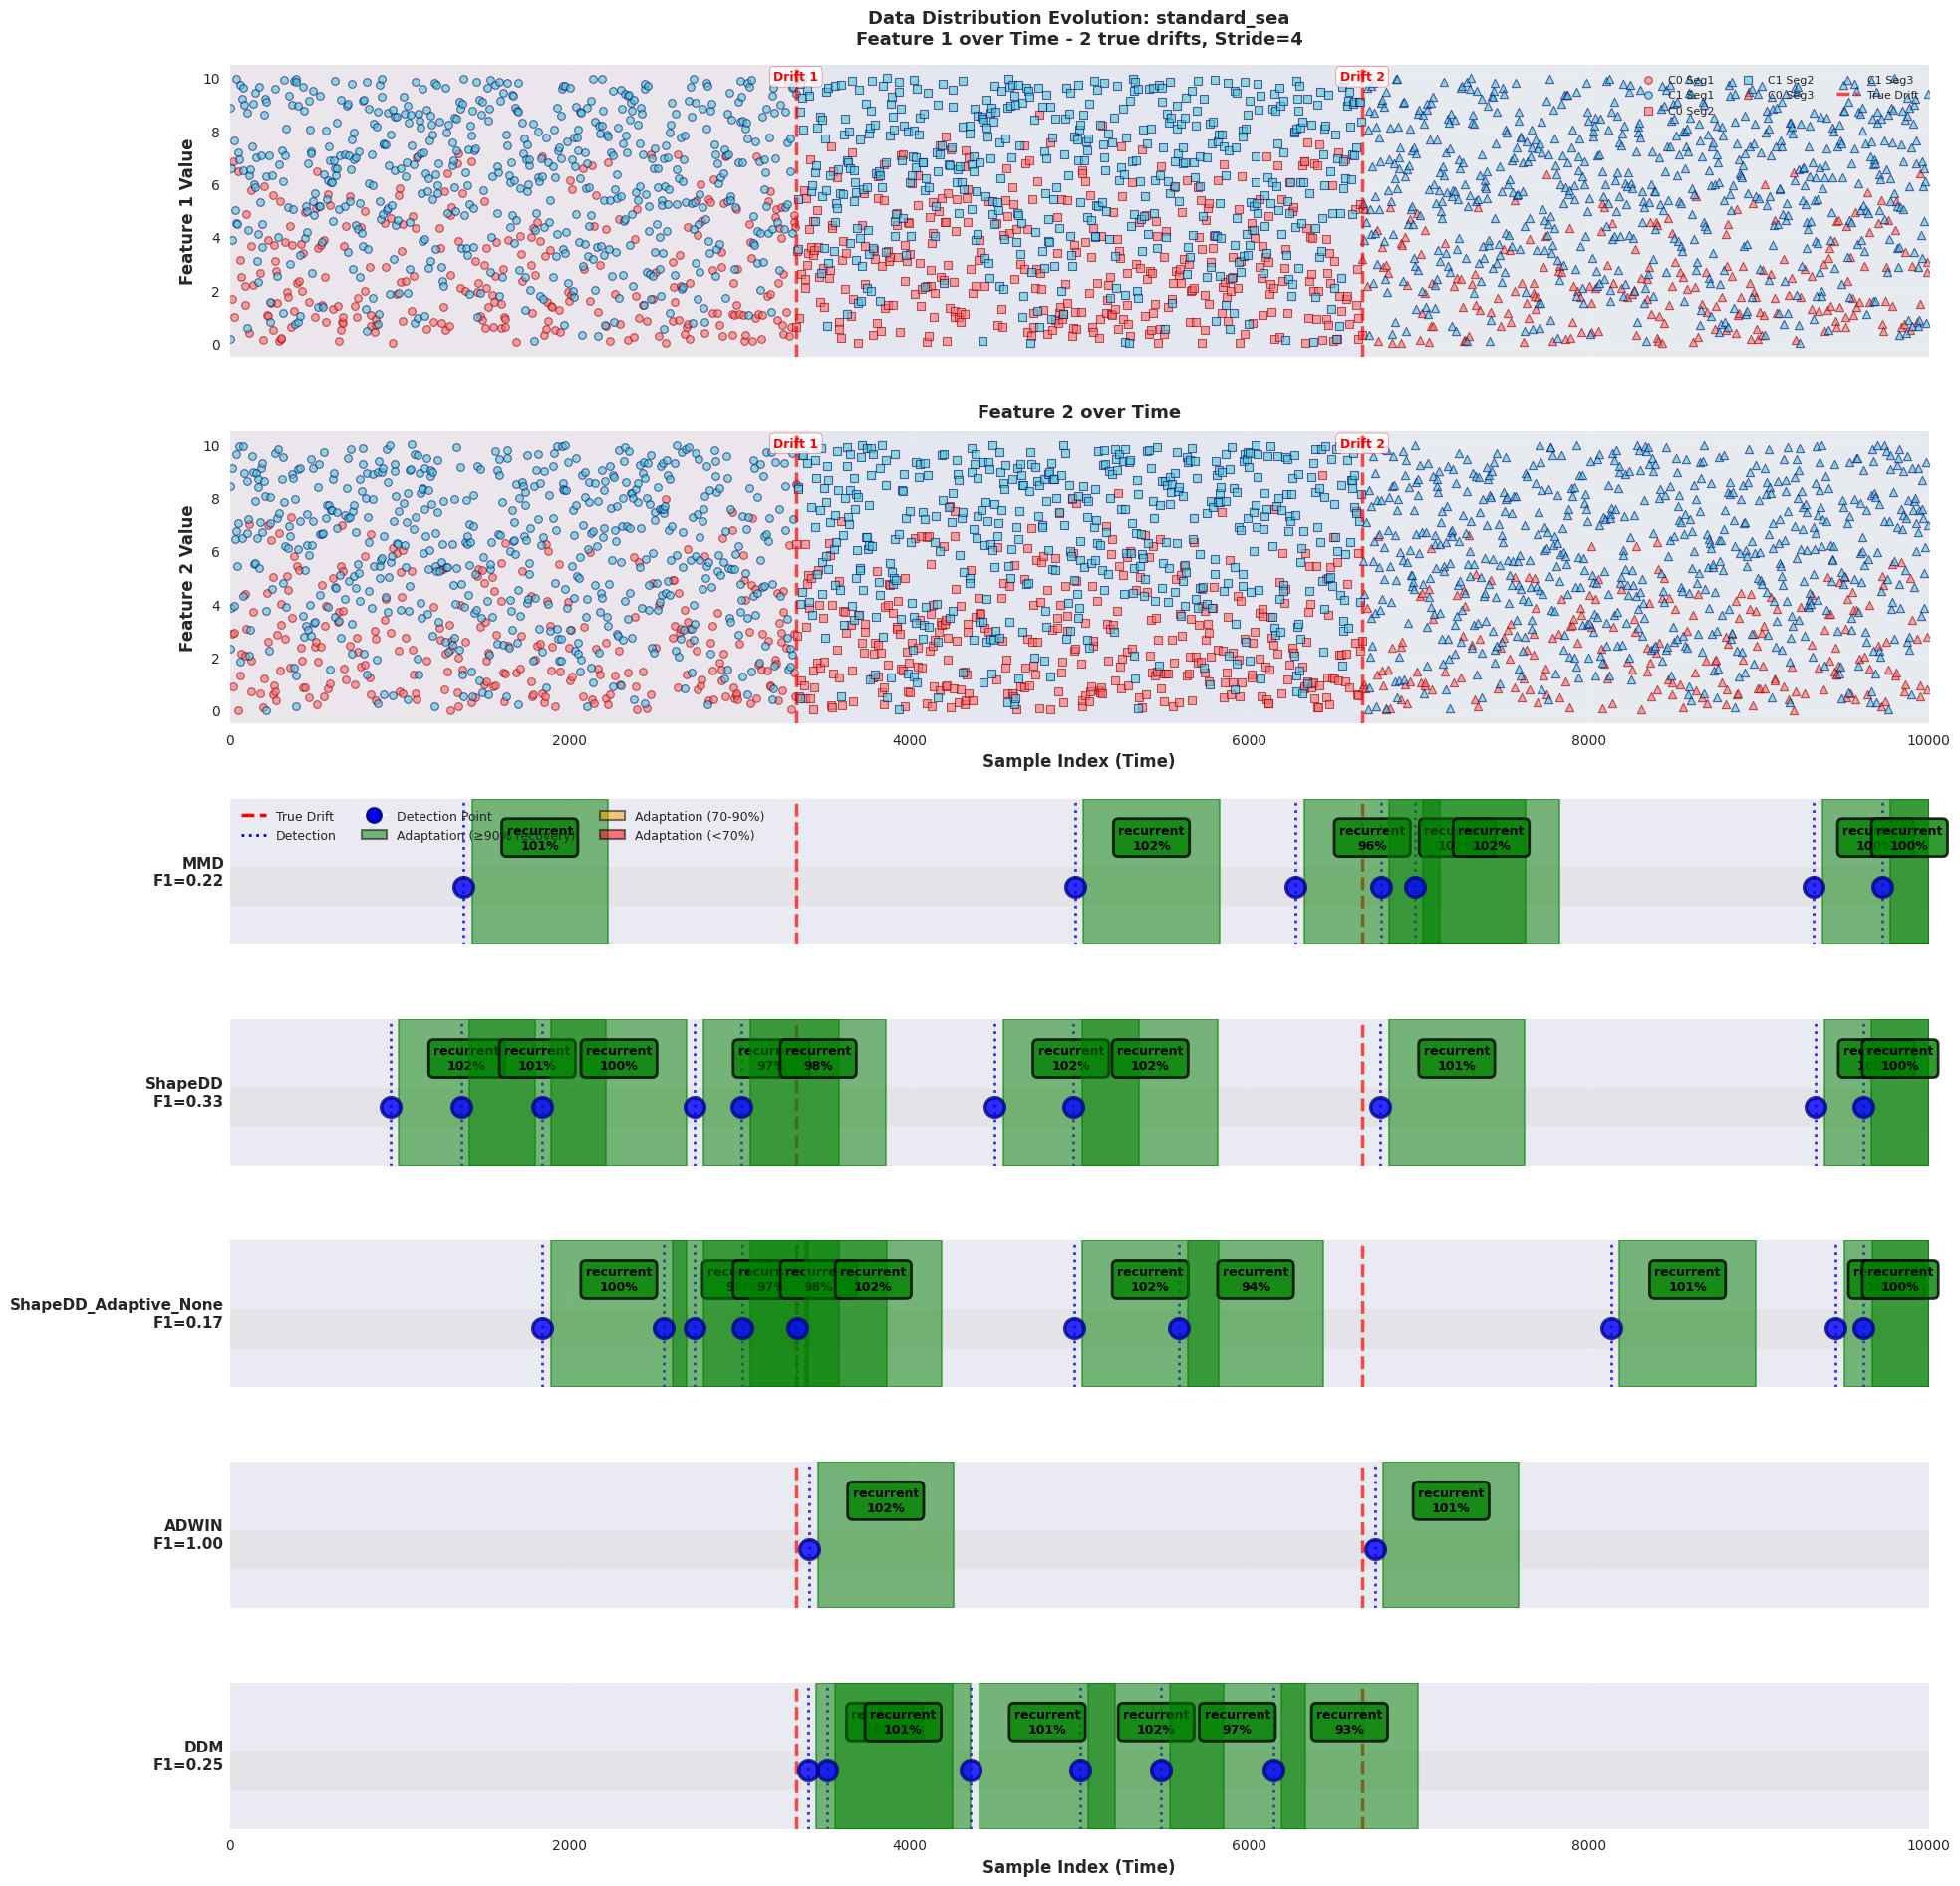

✓ Created distribution evolution visualization for standard_sea
  Generating enhanced_sea with 2 drift events...
  Enhanced SEA: 10000 samples, 3 features, 2 drifts


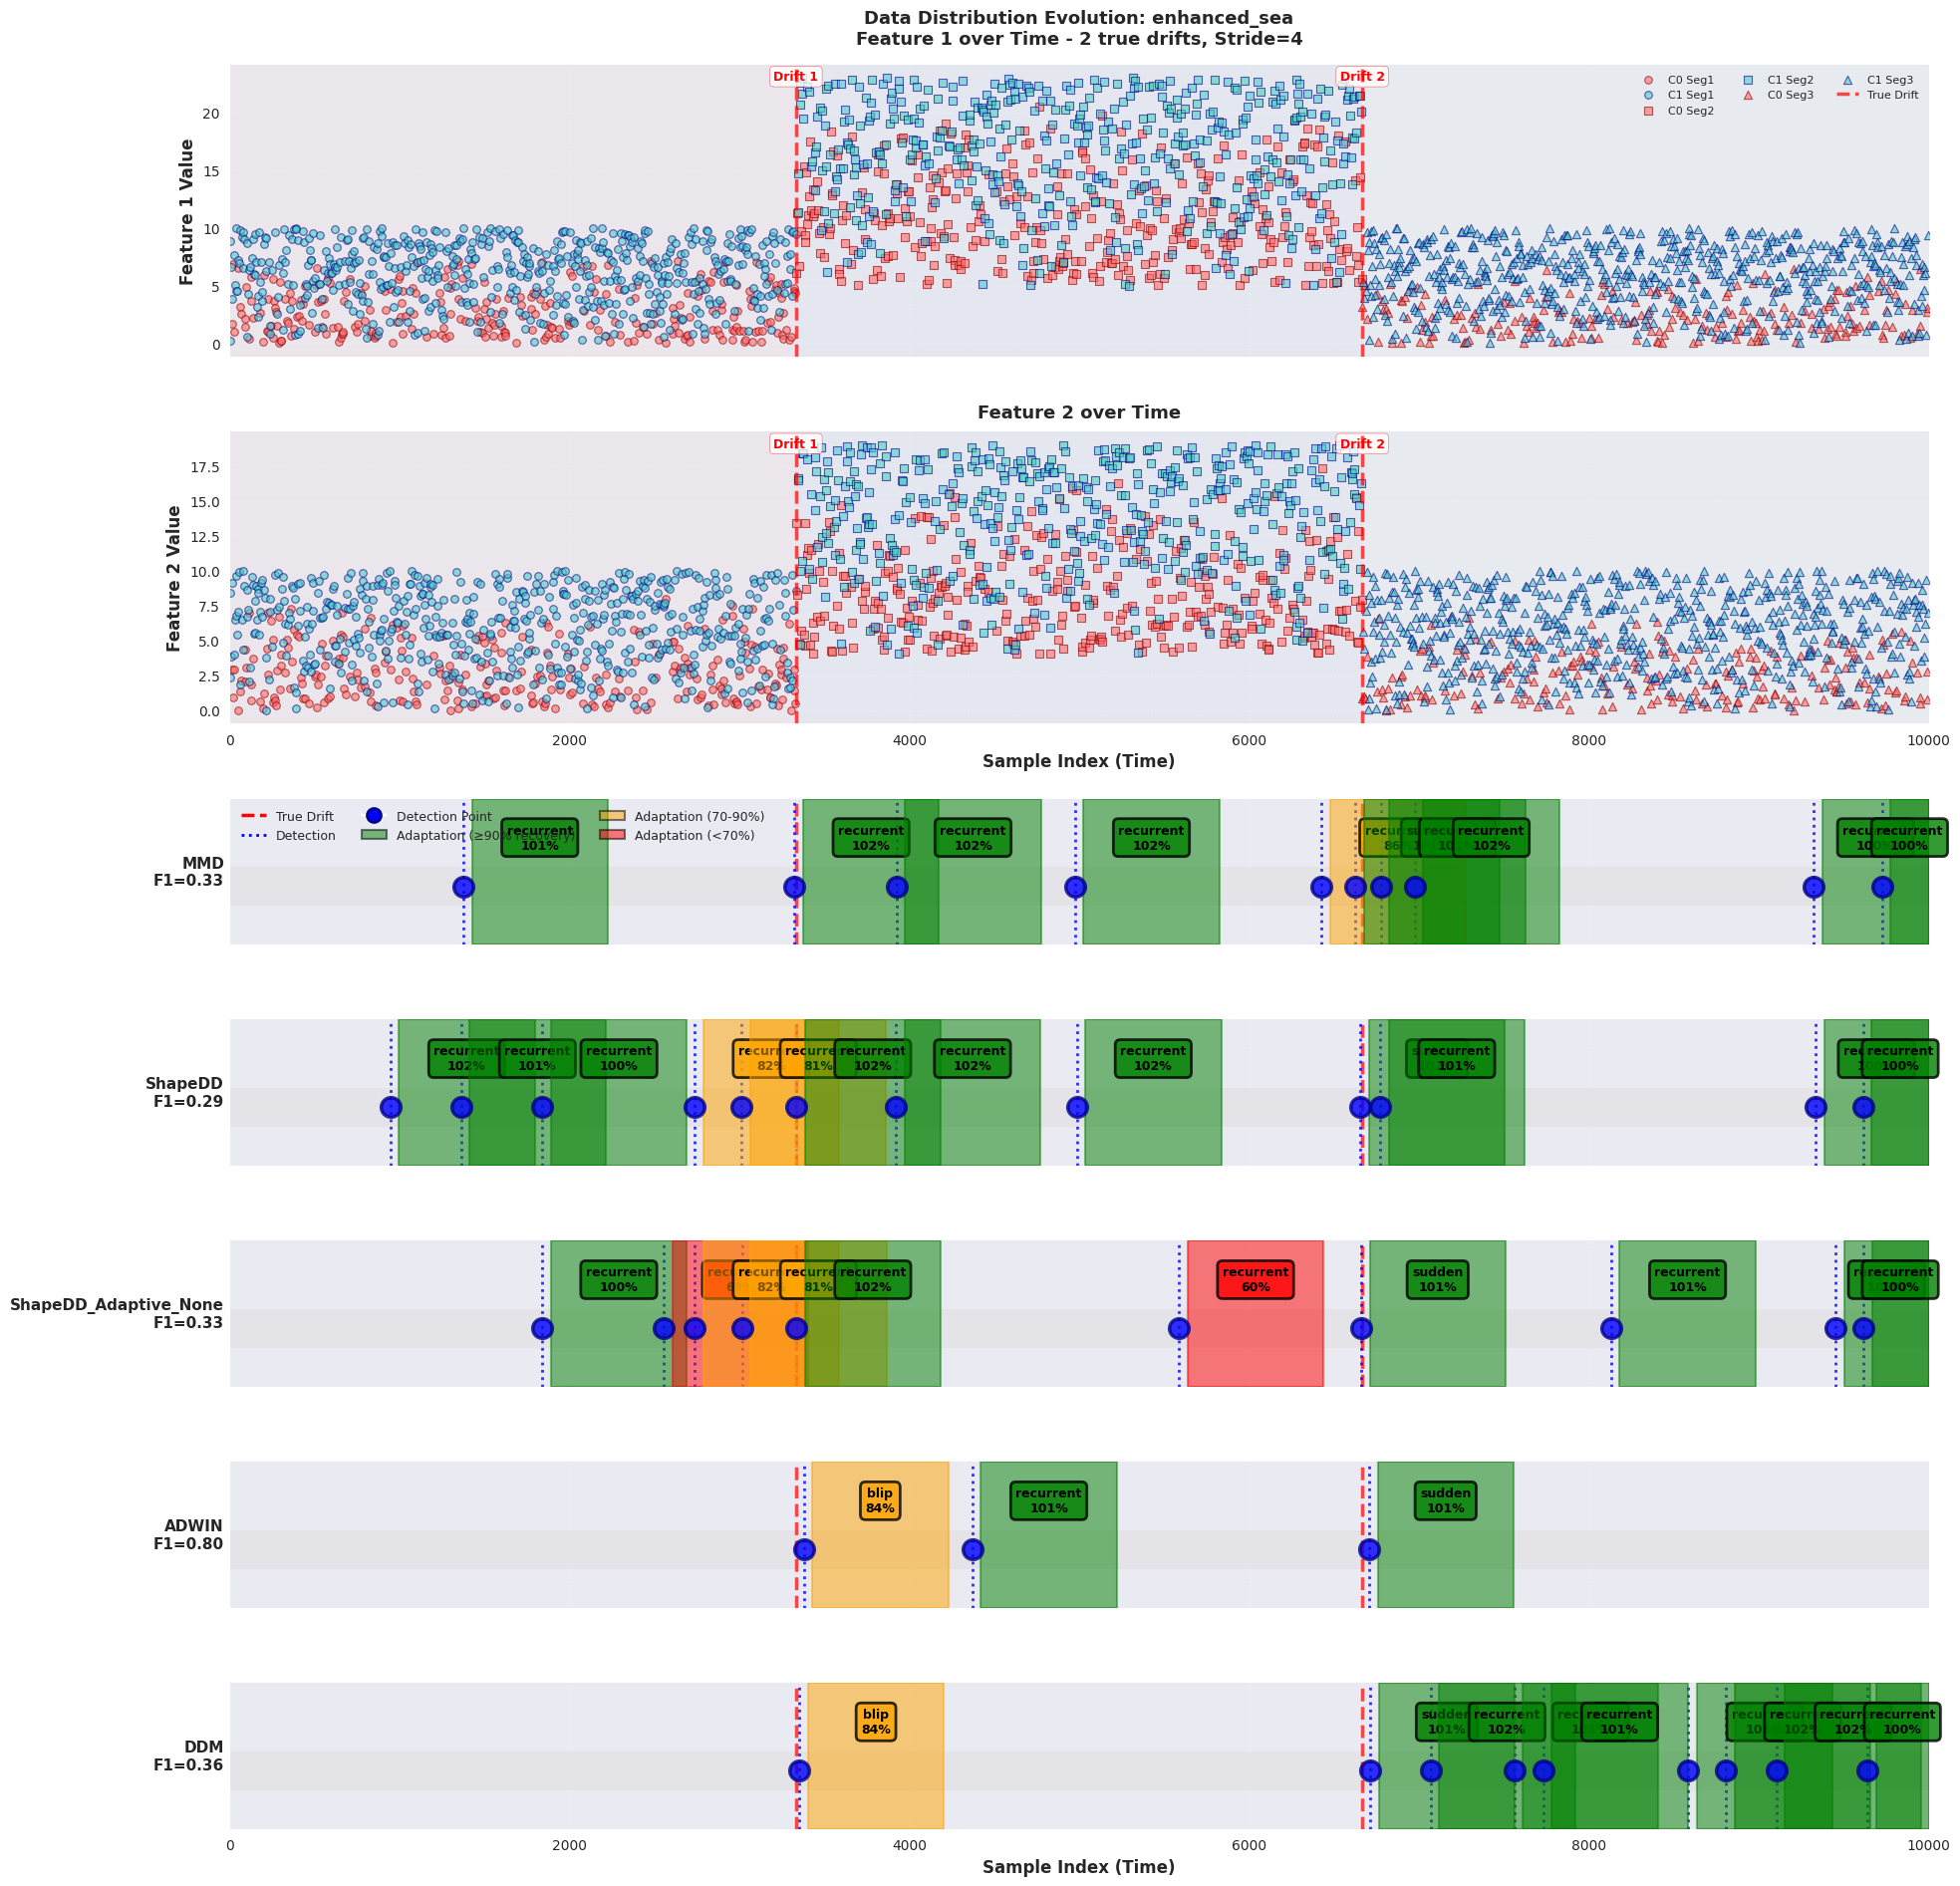

✓ Created distribution evolution visualization for enhanced_sea
  Generating stagger with 2 drift events...
  STAGGER: 10000 samples, 5 features, 2 drifts


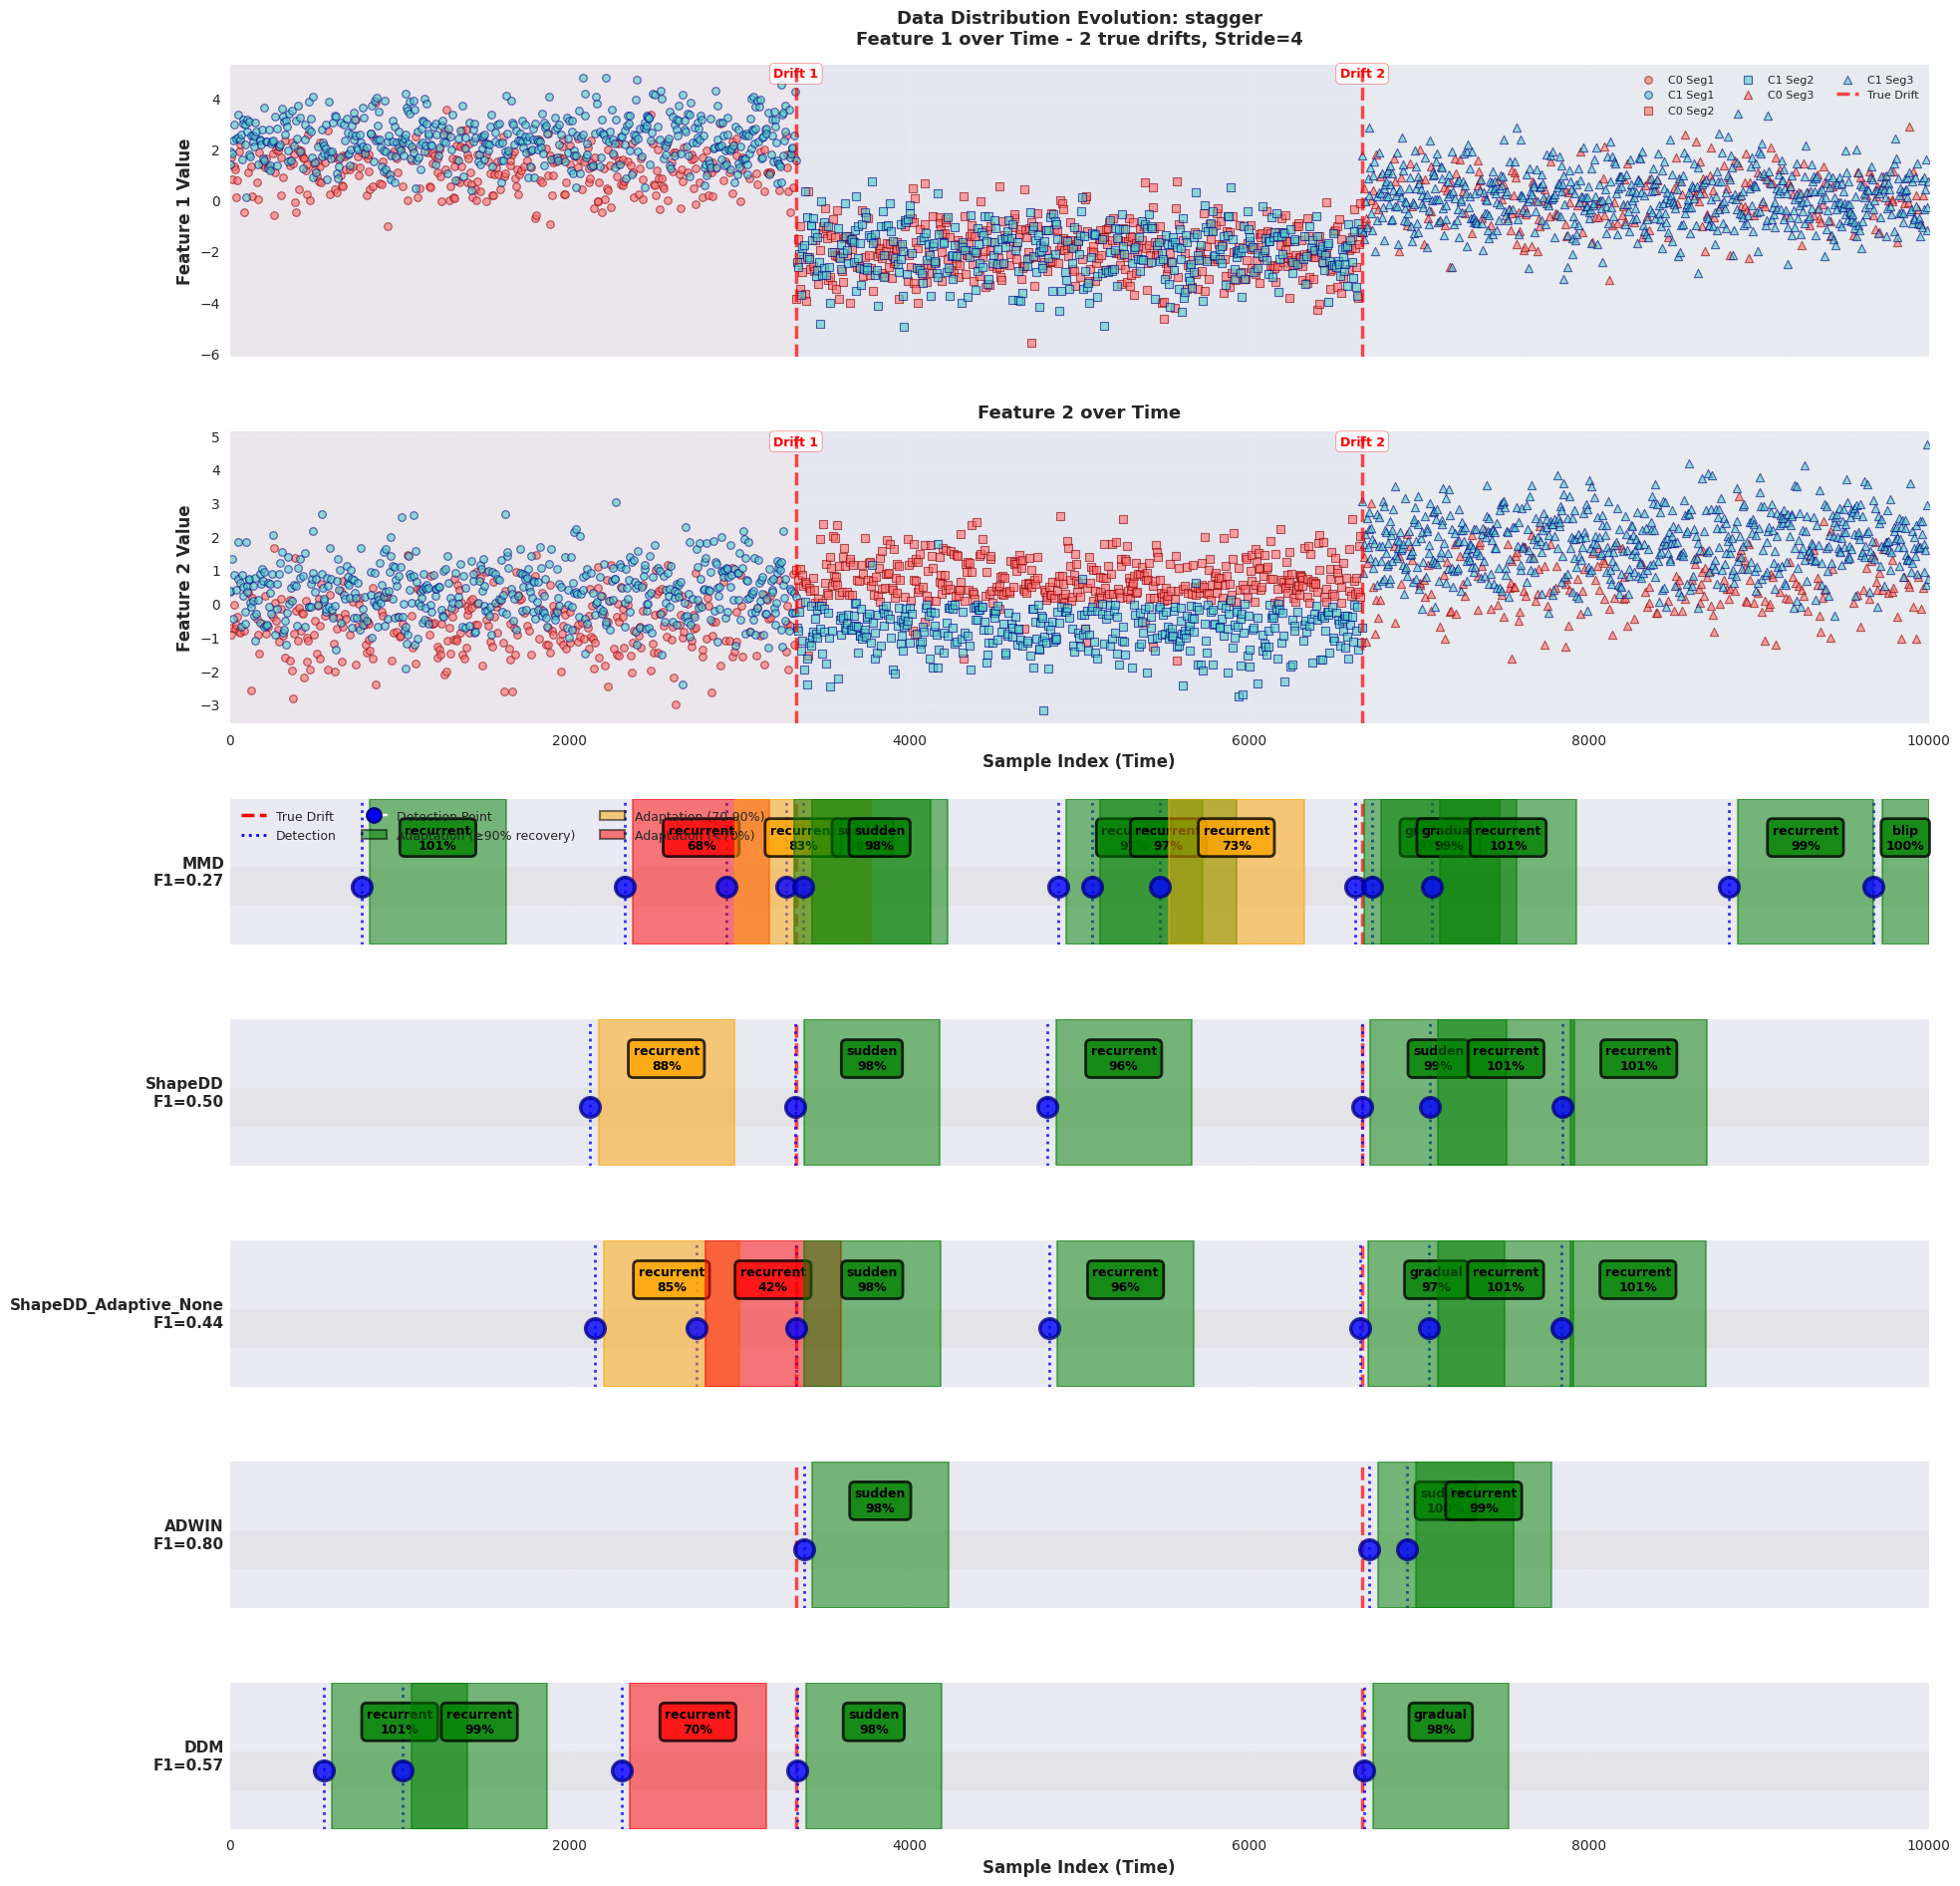

✓ Created distribution evolution visualization for stagger
  Generating hyperplane with 2 drift events...
  Hyperplane: 10000 samples, 10 features, 2 drifts


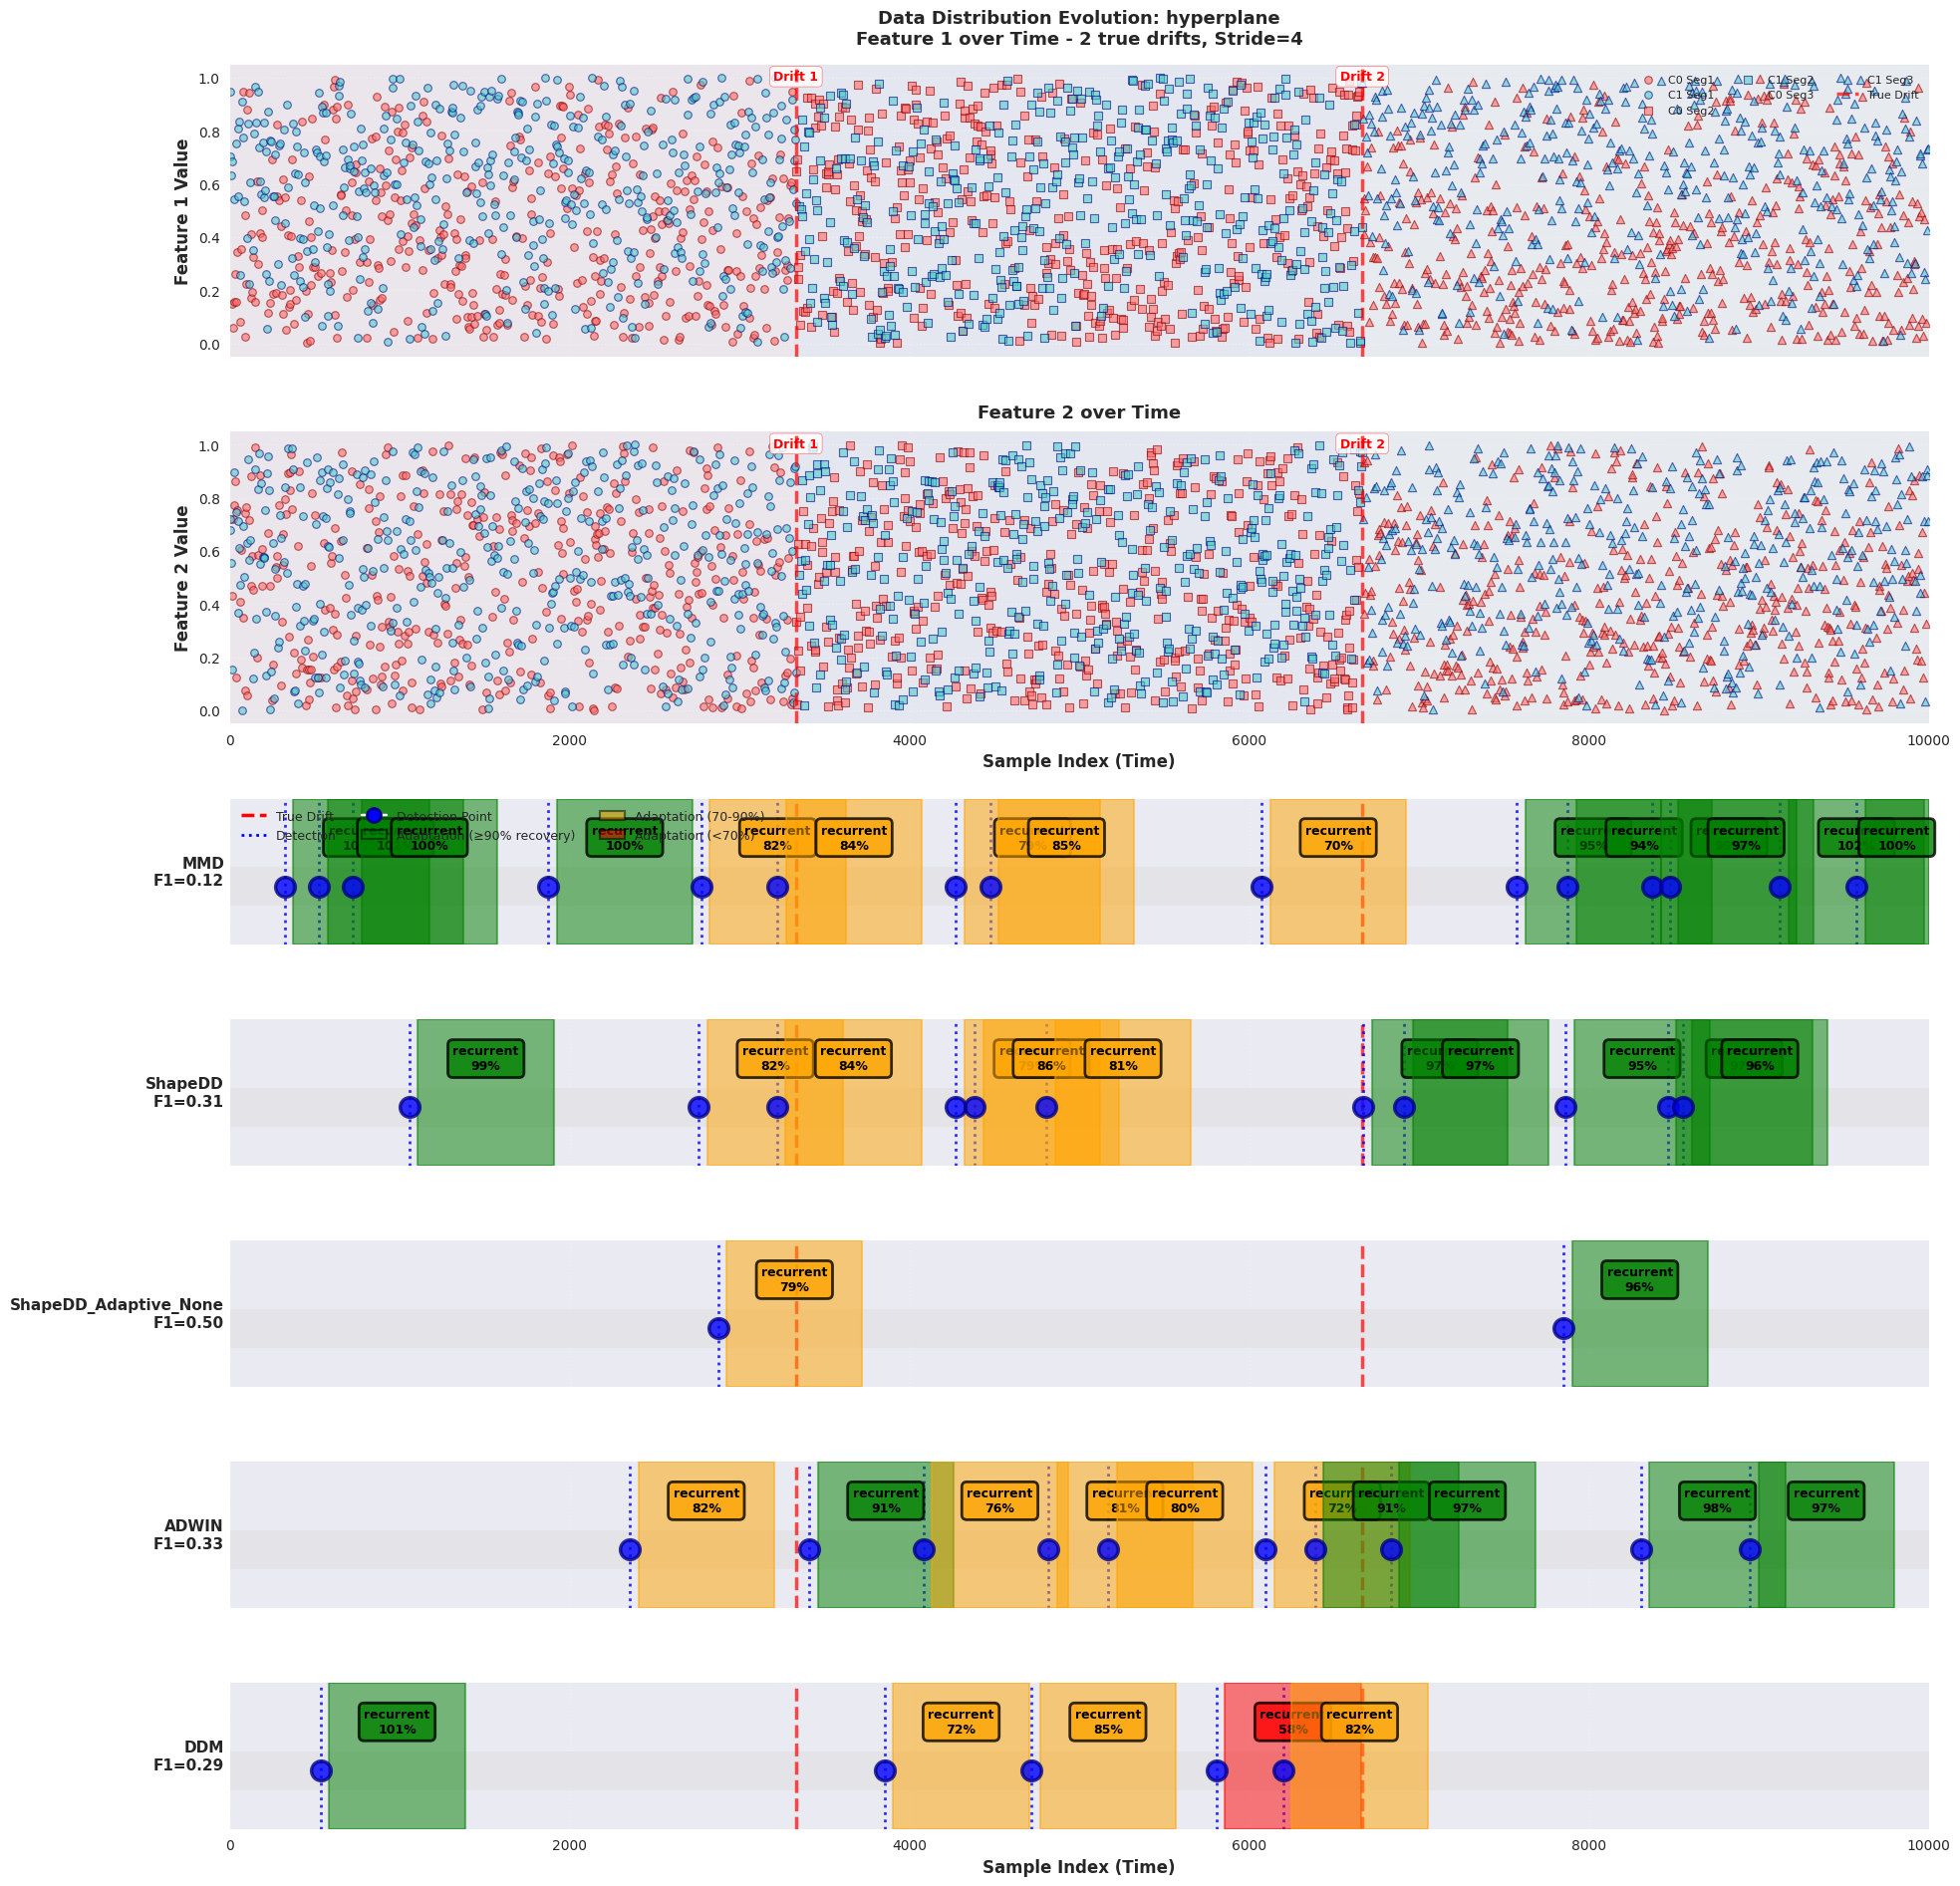

✓ Created distribution evolution visualization for hyperplane
  Generating gen_random with 3 drift events...
  gen_random: 10000 samples, 5 features, 3 drifts
  Synthetic labels: (array([0, 1]), array([5000, 5000]))


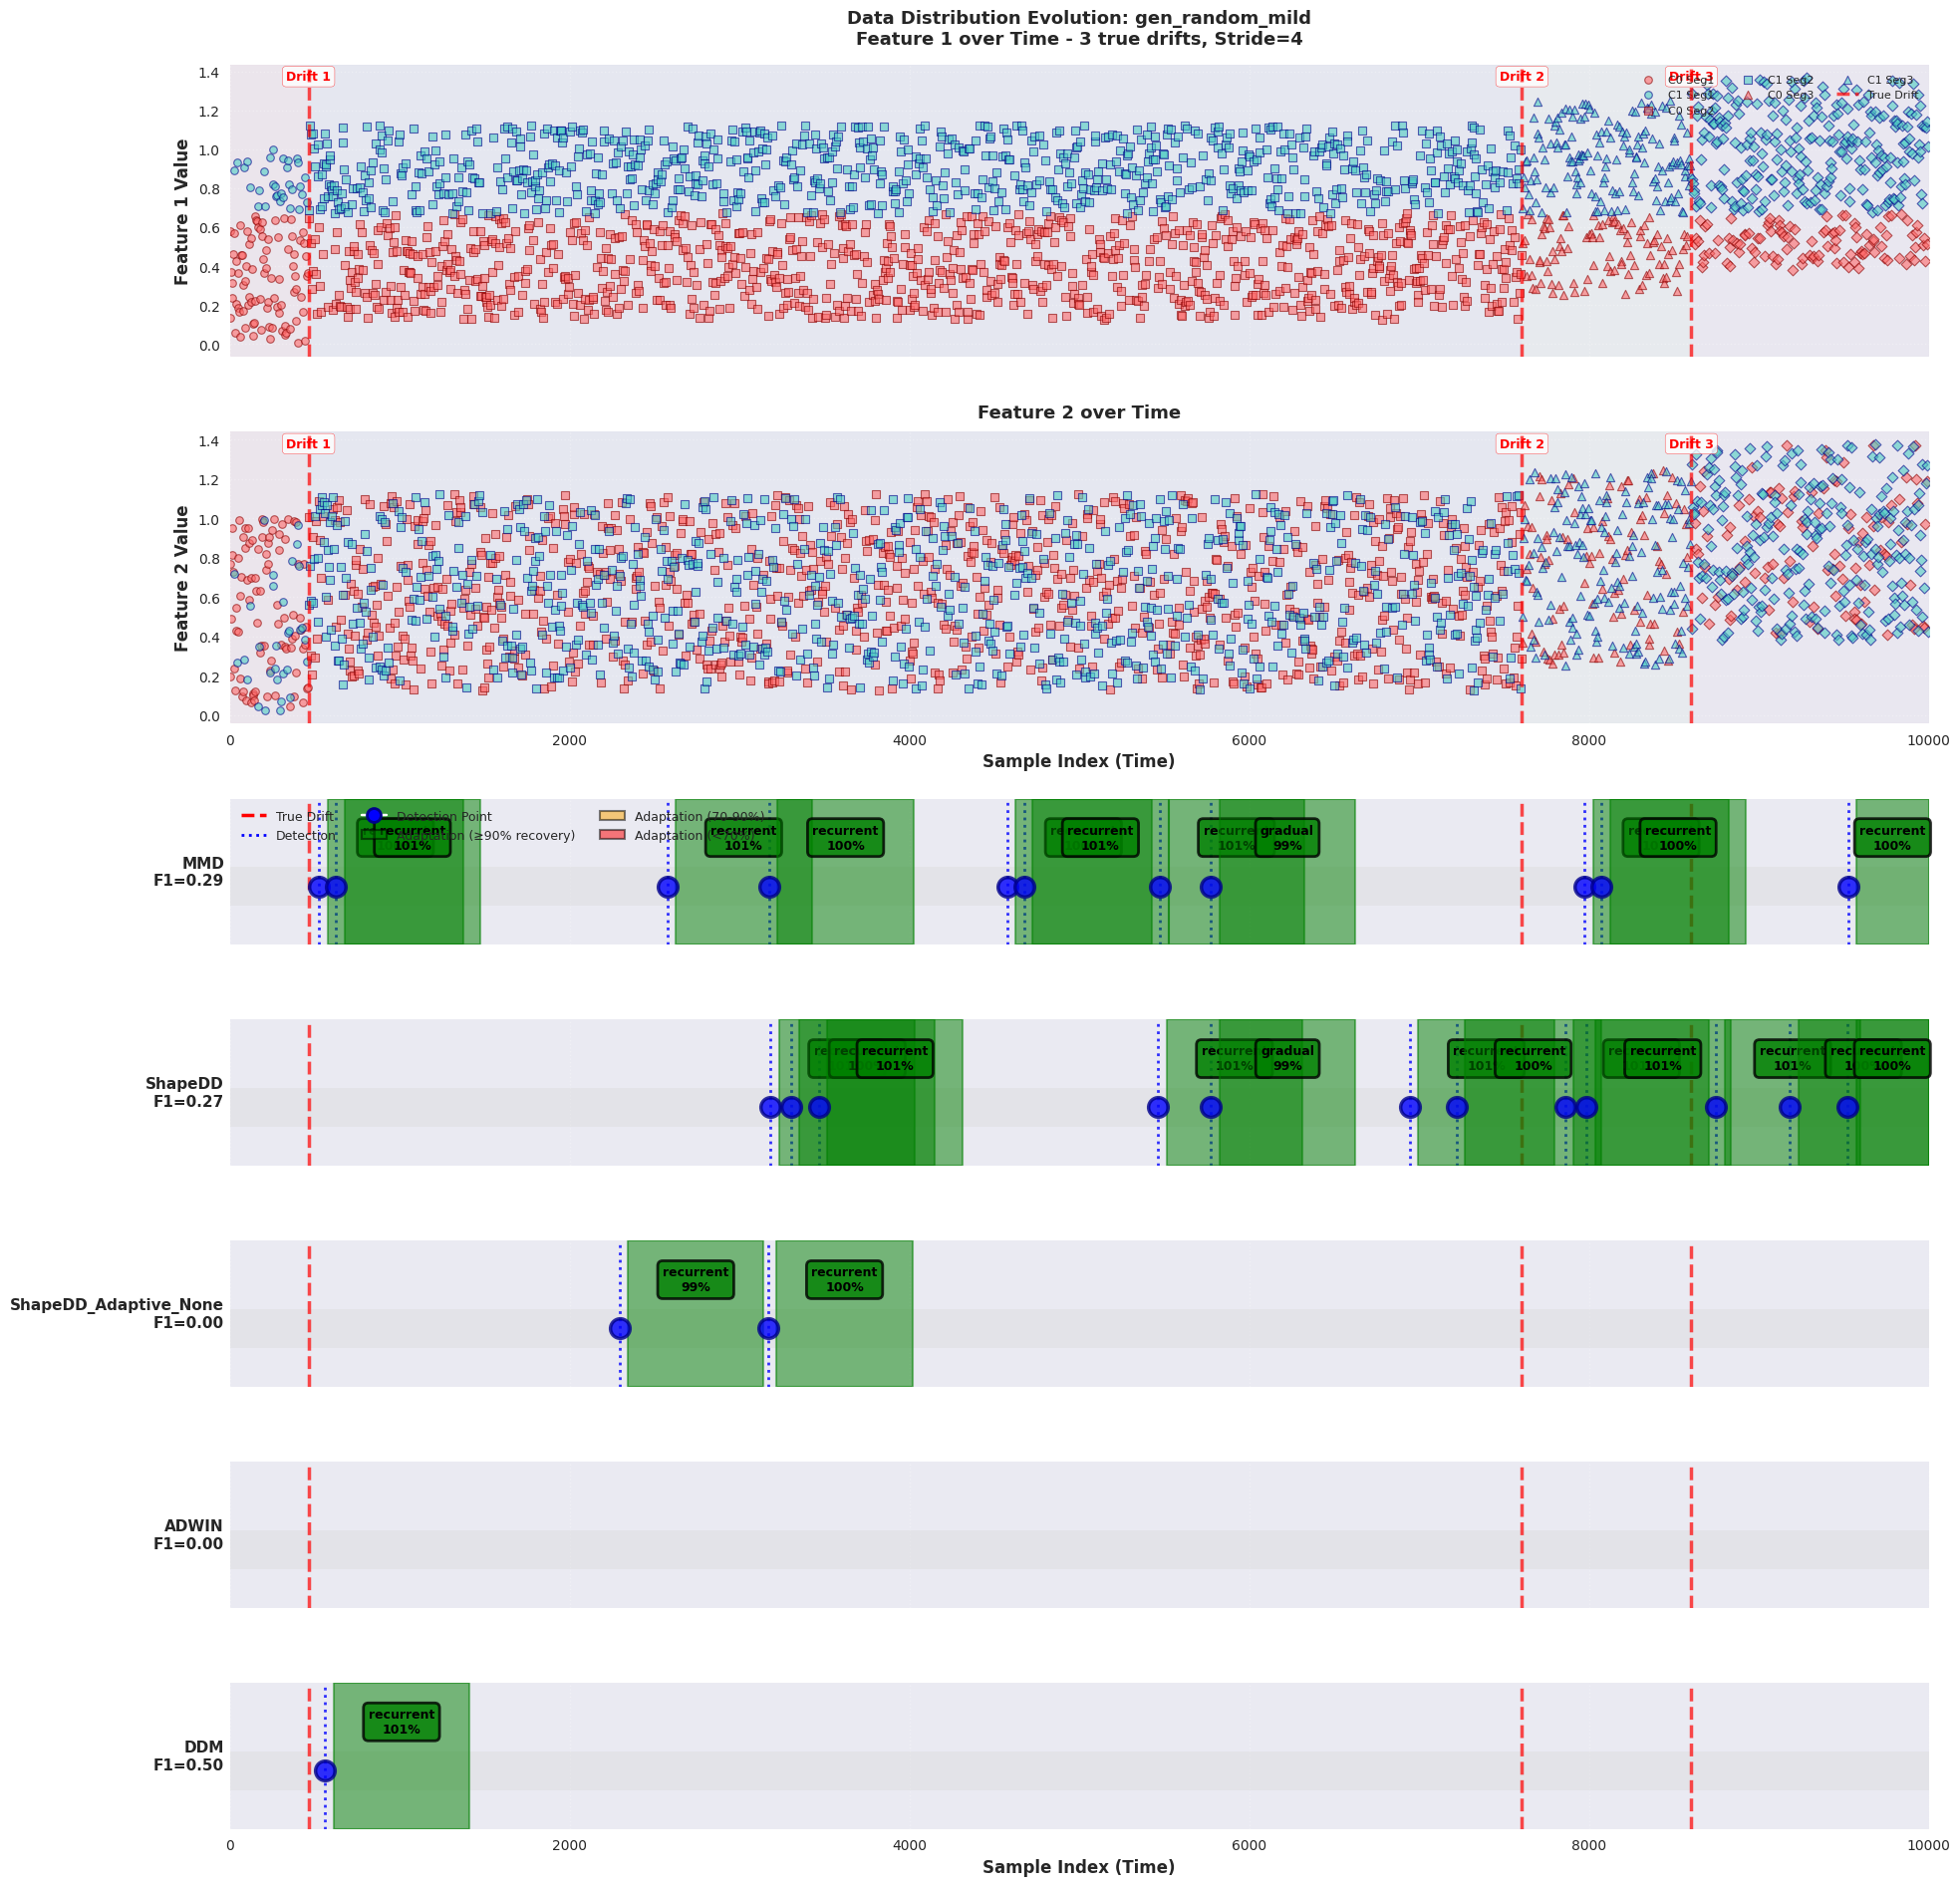

✓ Created distribution evolution visualization for gen_random_mild
  Generating gen_random with 3 drift events...
  gen_random: 10000 samples, 5 features, 3 drifts
  Synthetic labels: (array([0, 1]), array([5000, 5000]))


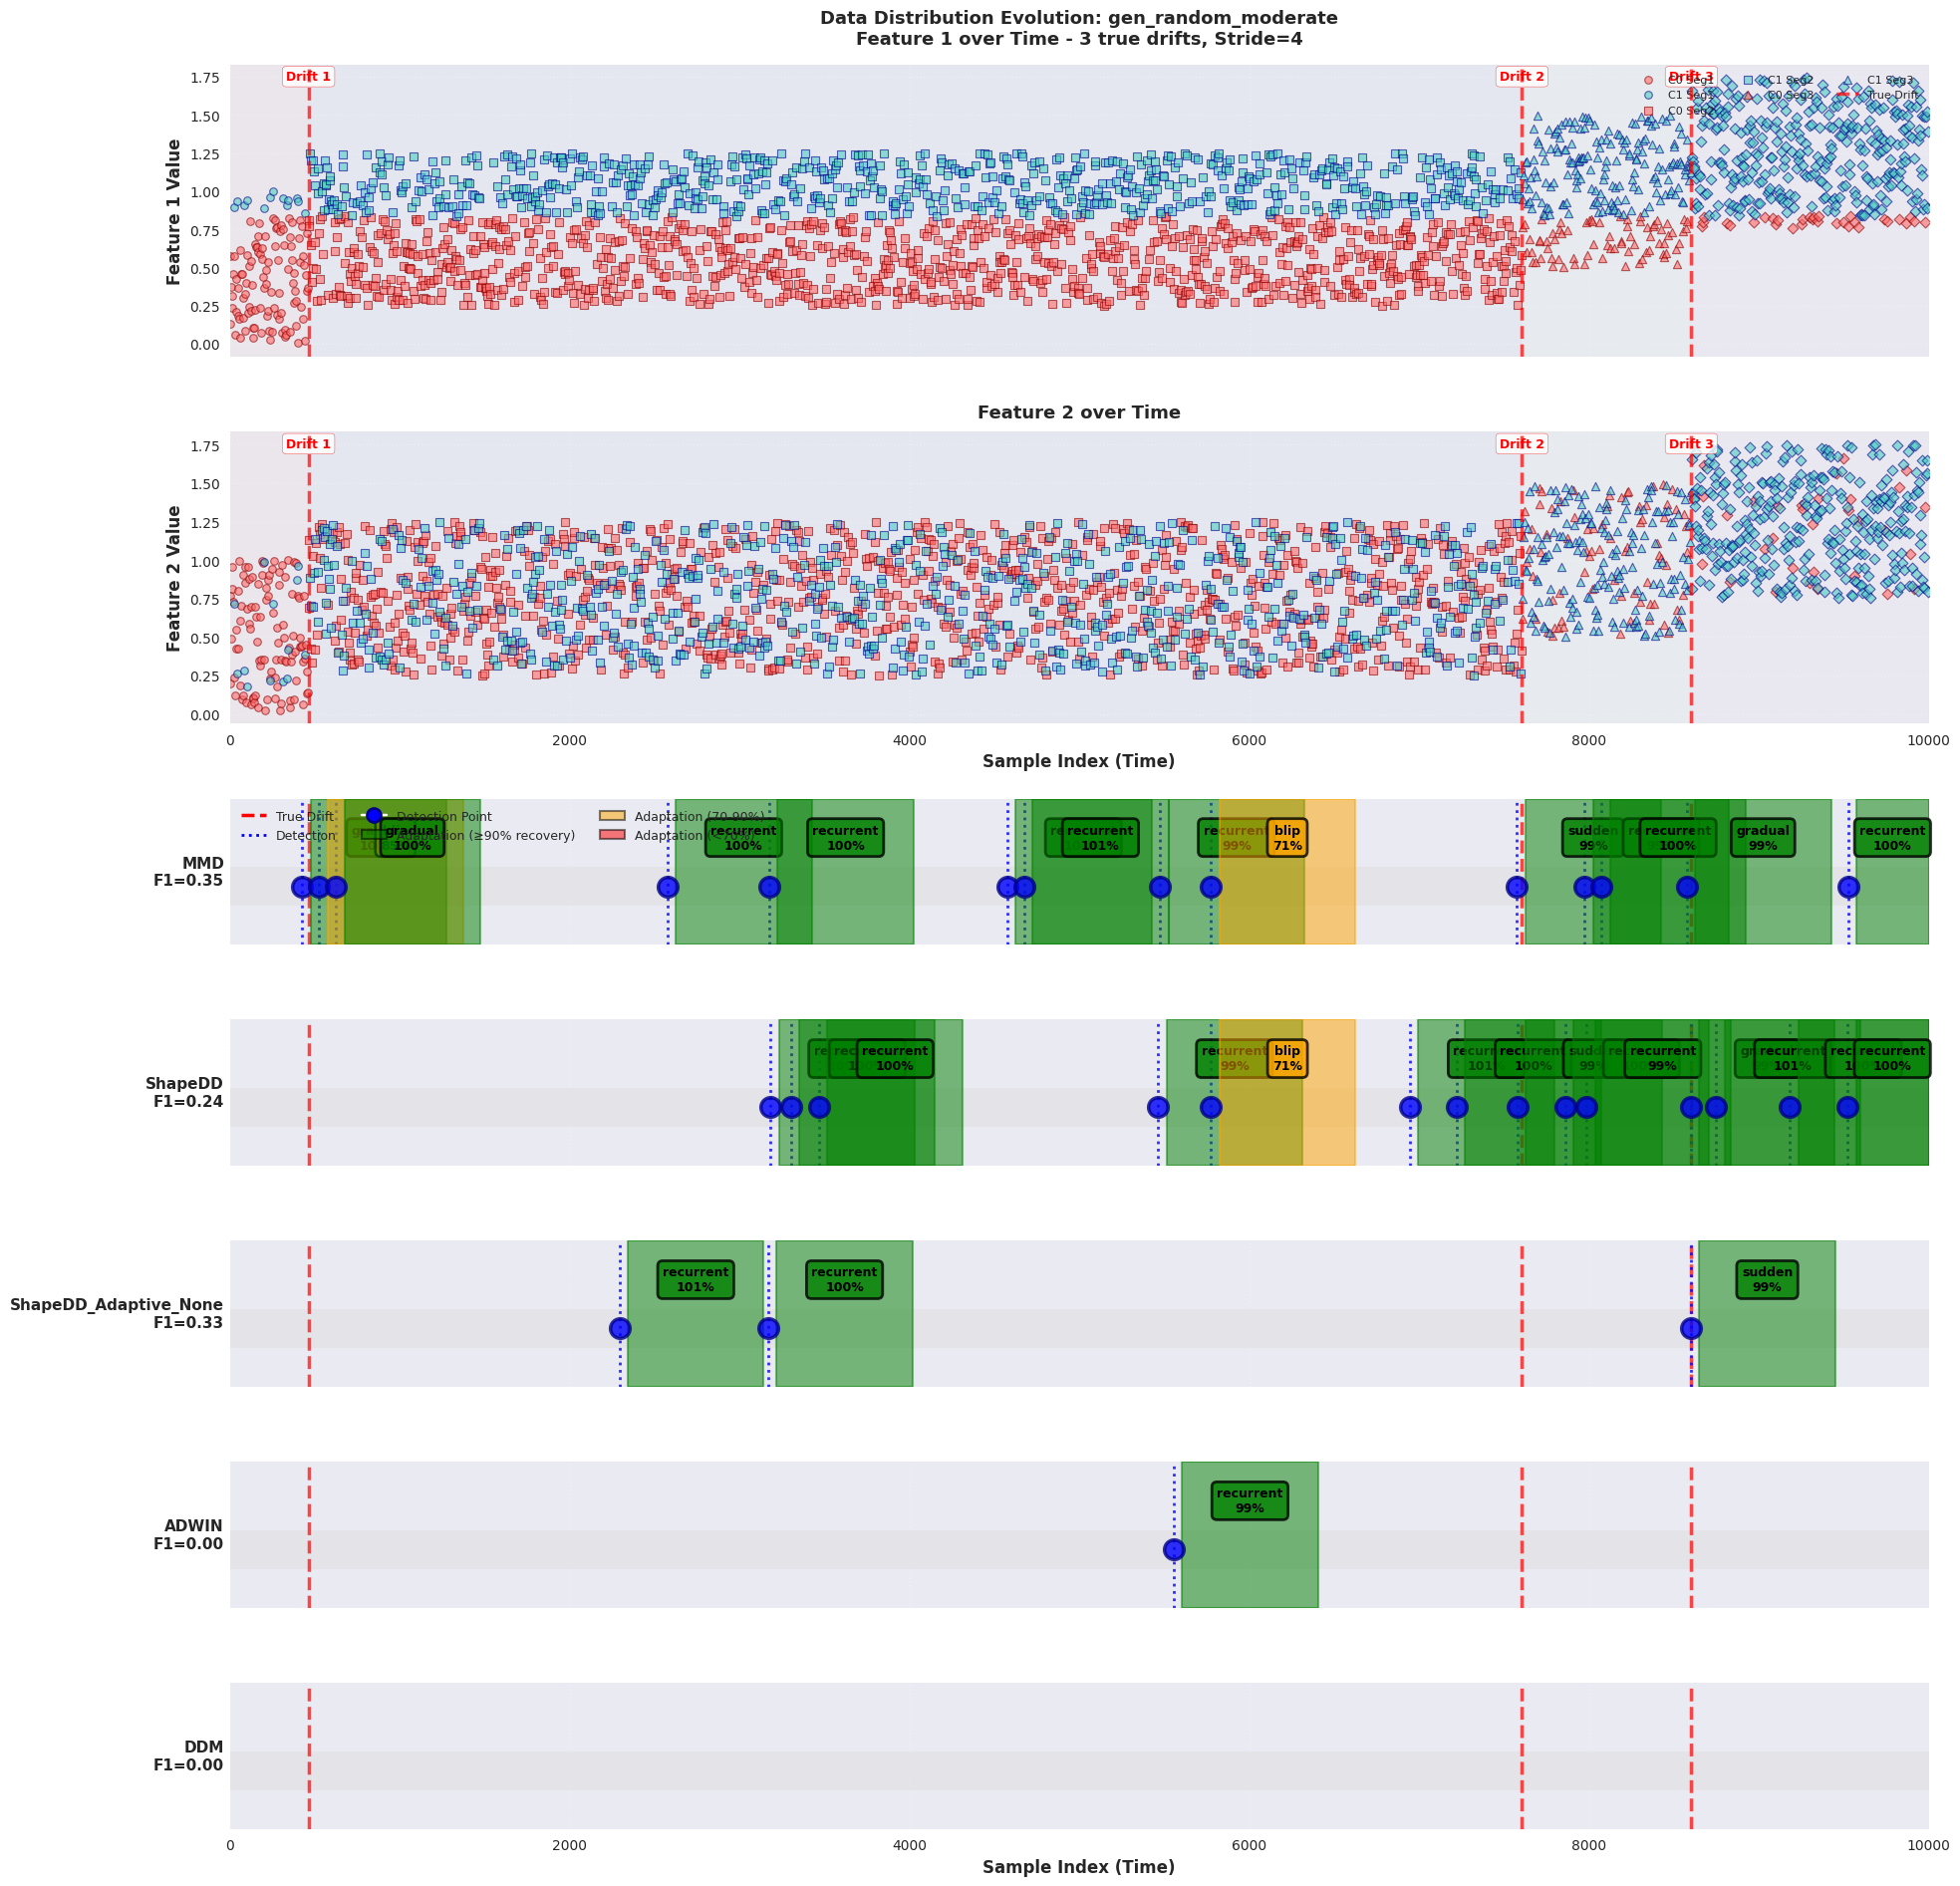

✓ Created distribution evolution visualization for gen_random_moderate
  Generating gen_random with 3 drift events...
  gen_random: 10000 samples, 5 features, 3 drifts
  Synthetic labels: (array([0, 1]), array([5000, 5000]))


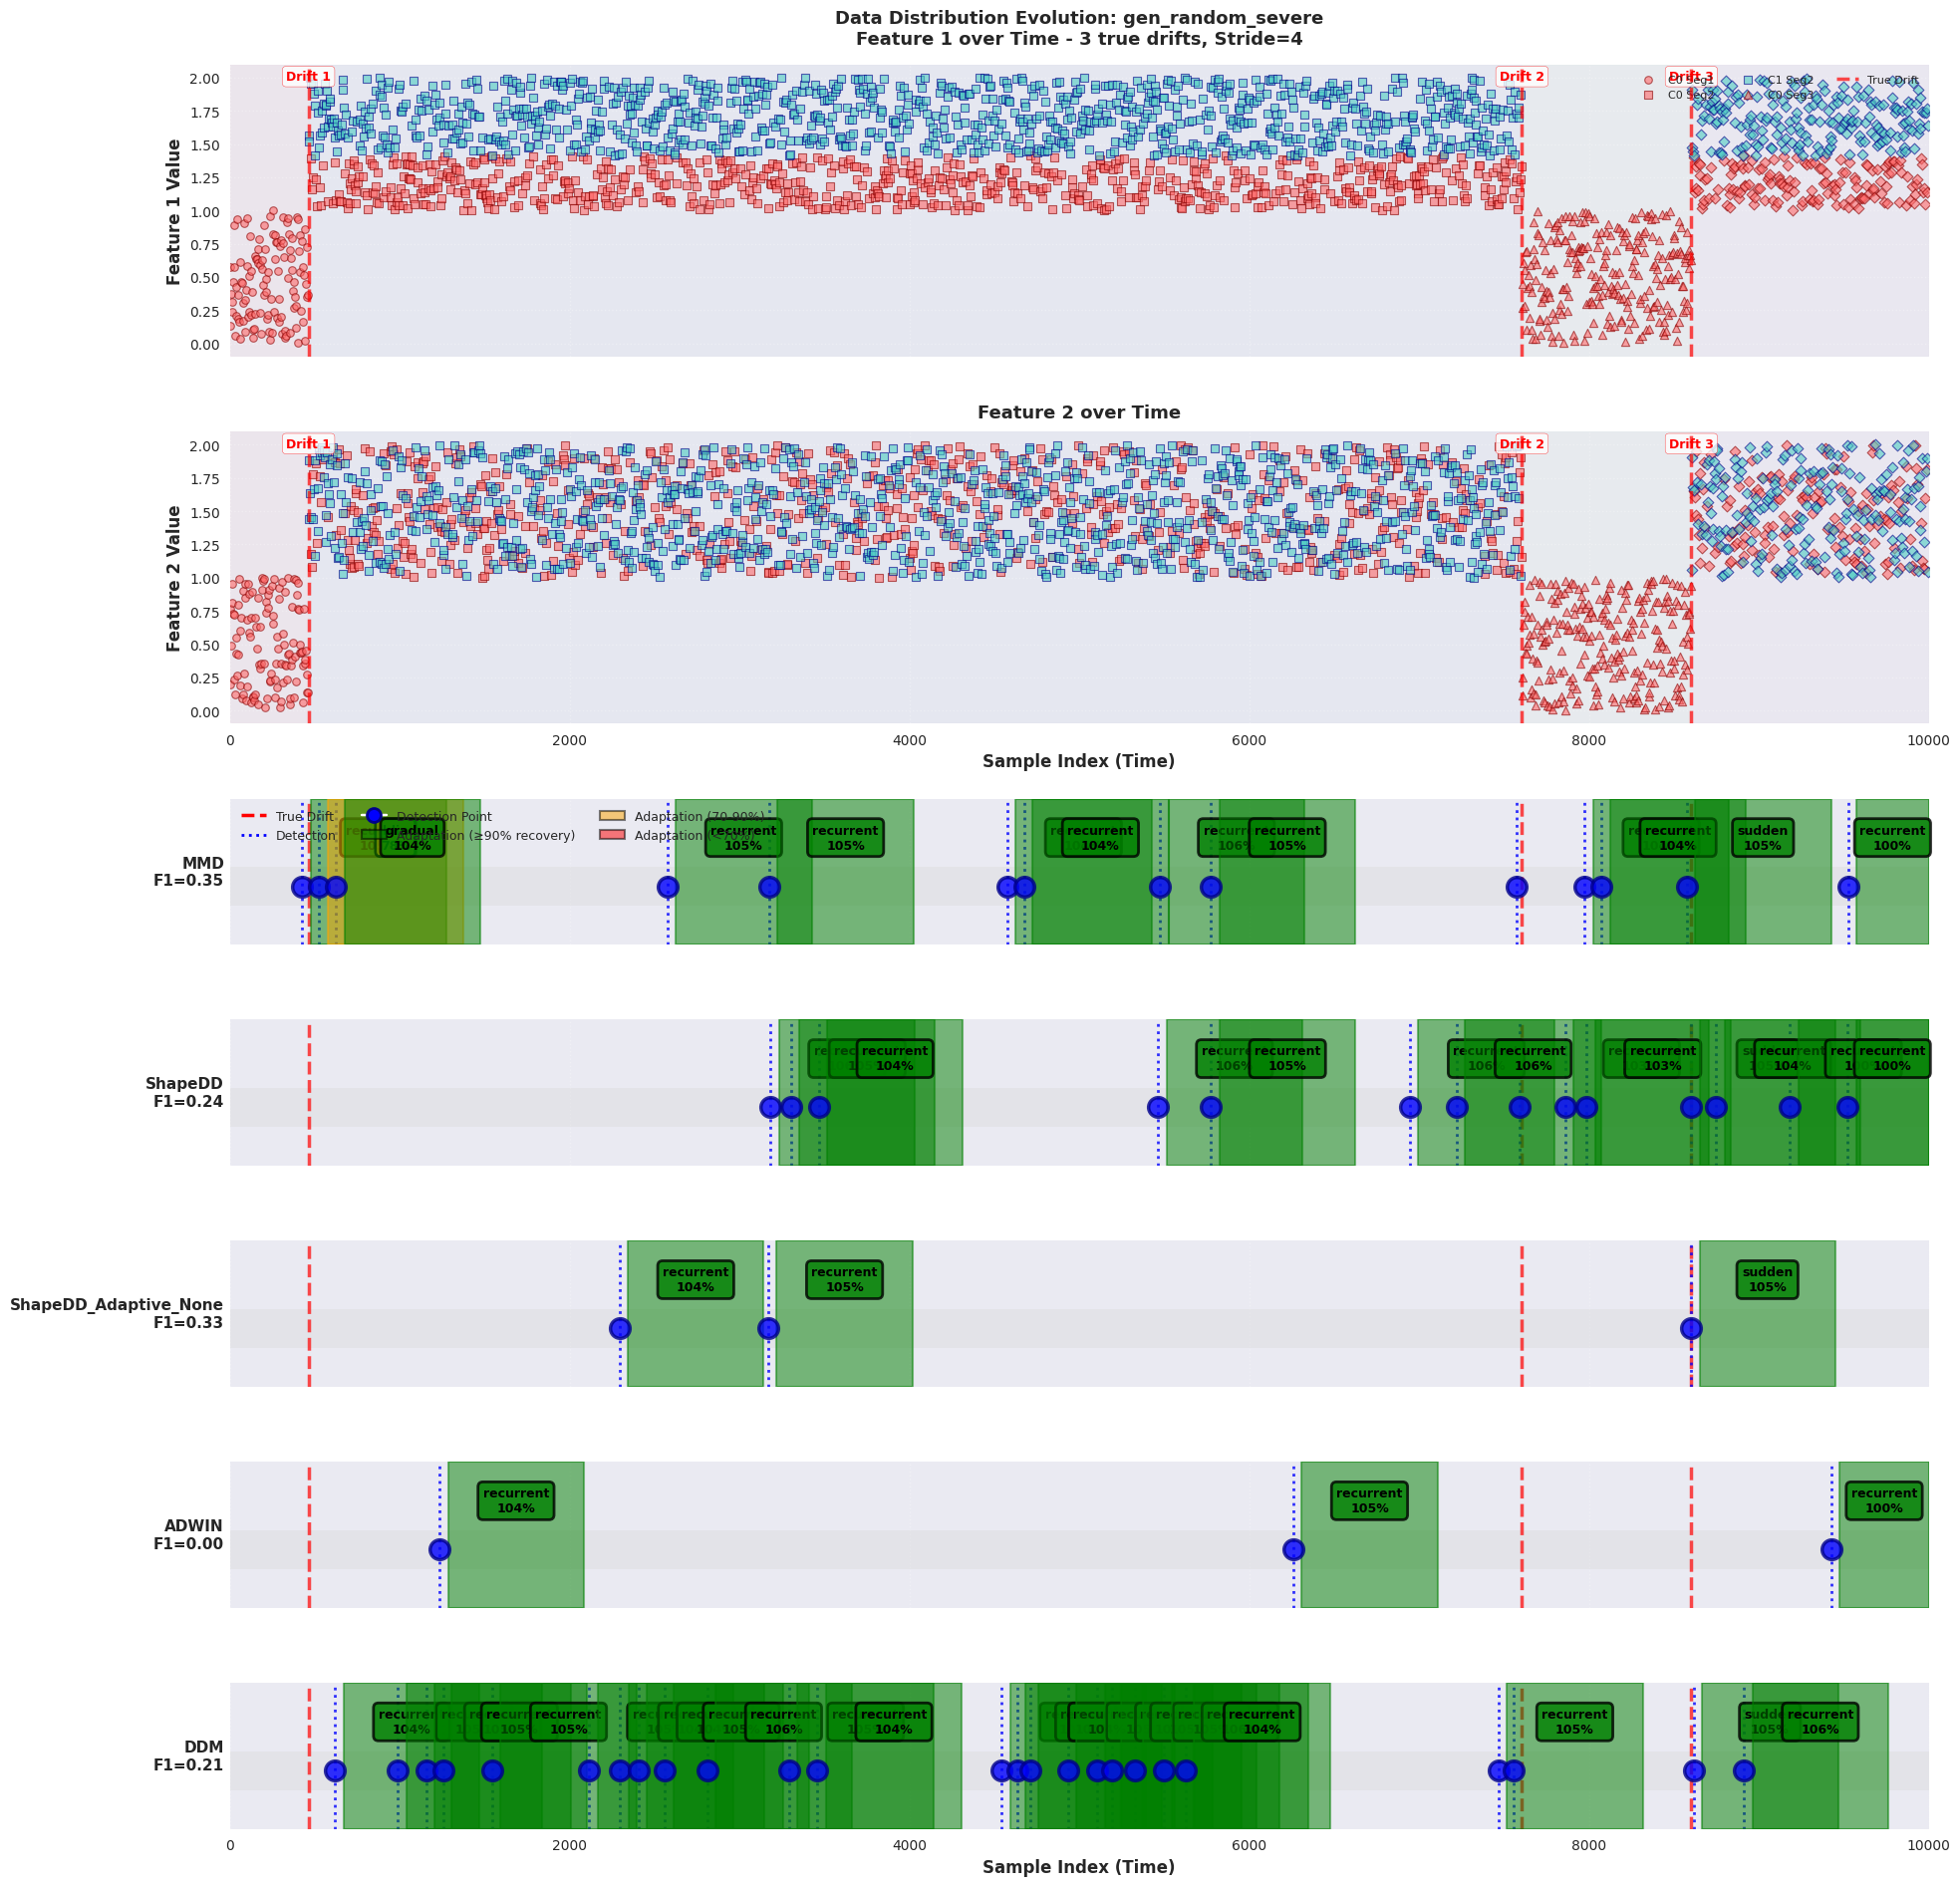

✓ Created distribution evolution visualization for gen_random_severe

✓ Distribution evolution visualizations complete

Visualization shows:
  - For 1D: Individual points over time with rolling statistics
  - For 2D: Feature 1 and Feature 2 plotted over TIME (not vs each other)
  - Different markers per drift segment
  - Class colors: Red (Class 0) vs Cyan (Class 1)
  - All aligned with detection timelines below


In [10]:
# ============================================================================
# SECTION 8B: VISUALIZATION - DATA DISTRIBUTION EVOLUTION + DETECTION
# ============================================================================

if len(all_results) == 0:
    print("⚠ No results to visualize")
else:
    print("Creating distribution evolution visualizations...")

    datasets = results_df['Dataset'].unique()

    for dataset_name in datasets:
        dataset_results = [r for r in all_results if r['dataset'] == dataset_name]

        if not dataset_results:
            continue

        # Get dataset info
        true_drifts = dataset_results[0]['drift_positions']
        adaptation_enabled = dataset_results[0].get('adaptation_enabled', False)

        # Re-generate dataset to plot (use same seed)
        dataset_config = DATASET_CATALOG[dataset_name]
        X, y, _, info = generate_drift_stream(
            dataset_config,
            total_size=STREAM_SIZE,
            seed=RANDOM_SEED
        )

        # Create figure with multiple subplots
        n_methods = len(dataset_results)
        n_features = min(X.shape[1], 2)

        # Adjust figure layout based on feature dimensionality
        if n_features == 1:
            fig = plt.figure(figsize=(22, 5 + 3*n_methods))
            gs_height_ratios = [3] + [1]*n_methods
        else:
            # For 2D: show both features over time
            fig = plt.figure(figsize=(22, 8 + 3*n_methods))
            gs_height_ratios = [2, 2] + [1]*n_methods

        # Use GridSpec for flexible layout
        import matplotlib.gridspec as gridspec
        gs = gridspec.GridSpec(len(gs_height_ratios), 1, height_ratios=gs_height_ratios, hspace=0.4)

        # Sample points for visualization
        sample_stride = max(1, len(X) // 2500)
        sample_indices = np.arange(0, len(X), sample_stride)
        X_sample = X[sample_indices]
        y_sample = y[sample_indices]

        if n_features == 1:
            # ============================================================
            # 1D VISUALIZATION: Show individual points over time
            # ============================================================
            ax_dist = plt.subplot(gs[0])

            # Create scatter plot with class colors
            colors_class0 = '#FF6B6B'  # Red
            colors_class1 = '#4ECDC4'  # Cyan

            # Plot class 0 and class 1 separately
            mask_class0 = y_sample == 0
            mask_class1 = y_sample == 1

            ax_dist.scatter(sample_indices[mask_class0], X_sample[mask_class0, 0],
                           c=colors_class0, s=10, alpha=0.6, edgecolors='darkred',
                           linewidth=0.5, label='Class 0')
            ax_dist.scatter(sample_indices[mask_class1], X_sample[mask_class1, 0],
                           c=colors_class1, s=10, alpha=0.6, edgecolors='darkblue',
                           linewidth=0.5, label='Class 1')

            # Add rolling mean and std for trend
            window_size = 500
            step_size = 100
            positions = []
            means = []
            stds = []

            for i in range(0, len(X) - window_size + 1, step_size):
                window = X[i:i+window_size, 0]
                positions.append(i + window_size // 2)
                means.append(np.mean(window))
                stds.append(np.std(window))

            positions = np.array(positions)
            means = np.array(means)
            stds = np.array(stds)

            # Plot mean trend line
            ax_dist.plot(positions, means, color='darkblue', linewidth=3,
                        label='Rolling Mean', zorder=5, alpha=0.8)
            ax_dist.fill_between(positions, means - stds, means + stds,
                                alpha=0.15, color='darkblue', label='±1 Std Dev', zorder=4)

            # Mark true drift positions
            ylim = ax_dist.get_ylim()
            for i, drift_pos in enumerate(true_drifts):
                ax_dist.axvline(drift_pos, color='red', linestyle='--', linewidth=2.5,
                               alpha=0.7, zorder=10, label='True Drift' if i == 0 else '')
                ax_dist.text(drift_pos, ylim[1] * 0.98, f'Drift {i+1}\n({drift_pos})',
                           ha='center', va='top', fontweight='bold',
                           color='red', fontsize=10,
                           bbox=dict(boxstyle='round,pad=0.5', facecolor='white',
                                    edgecolor='red', alpha=0.8))

            # Add shaded regions between drifts
            drift_bounds = [0] + true_drifts + [STREAM_SIZE]
            for i in range(len(drift_bounds) - 1):
                color = plt.cm.Pastel1(i % 9)
                ax_dist.axvspan(drift_bounds[i], drift_bounds[i+1],
                               alpha=0.1, color=color, zorder=0)

            ax_dist.set_ylabel('Feature 1 Value', fontsize=12, fontweight='bold')
            ax_dist.set_xlabel('Sample Index (Time)', fontsize=12, fontweight='bold')
            ax_dist.legend(loc='upper right', fontsize=10, framealpha=0.9)
            ax_dist.set_xlim([0, STREAM_SIZE])
            ax_dist.grid(alpha=0.3, linestyle=':', linewidth=1)

            ax_dist.set_title(f'Data Distribution Evolution: {dataset_name}\n' +
                             f'{info["n_features"]} features, {len(true_drifts)} true drifts' +
                             f' - Stride={sample_stride}',
                             fontsize=14, fontweight='bold', pad=20)

            method_panel_offset = 1

        else:
            # ============================================================
            # 2D VISUALIZATION: Show Feature 1 and Feature 2 over TIME
            # ============================================================

            colors_class0 = '#FF6B6B'  # Red
            colors_class1 = '#4ECDC4'  # Cyan

            # Determine which drift regions for different markers
            drift_segments = [0] + true_drifts + [len(X)]
            markers = ['o', 's', '^', 'D', 'v', 'p', '*']
            marker_sizes = [30, 35, 35, 30, 35, 35, 40]

            # PANEL 1: Feature 1 vs Time
            ax_f1 = plt.subplot(gs[0])

            for seg_idx in range(len(drift_segments) - 1):
                seg_start = drift_segments[seg_idx]
                seg_end = drift_segments[seg_idx + 1]

                # Find samples in this segment
                seg_mask = (sample_indices >= seg_start) & (sample_indices < seg_end)

                if not np.any(seg_mask):
                    continue

                # Separate by class
                seg_class0 = seg_mask & (y_sample == 0)
                seg_class1 = seg_mask & (y_sample == 1)

                marker = markers[seg_idx % len(markers)]
                marker_size = marker_sizes[seg_idx % len(marker_sizes)]
                label_suffix = f' Seg{seg_idx + 1}'

                # Plot class 0 in this segment
                if np.any(seg_class0):
                    ax_f1.scatter(sample_indices[seg_class0], X_sample[seg_class0, 0],
                                 c=colors_class0, marker=marker, s=marker_size, alpha=0.6,
                                 edgecolors='darkred', linewidth=0.8,
                                 label=f'C0{label_suffix}' if seg_idx < 3 else None)

                # Plot class 1 in this segment
                if np.any(seg_class1):
                    ax_f1.scatter(sample_indices[seg_class1], X_sample[seg_class1, 0],
                                 c=colors_class1, marker=marker, s=marker_size, alpha=0.6,
                                 edgecolors='darkblue', linewidth=0.8,
                                 label=f'C1{label_suffix}' if seg_idx < 3 else None)

            # Mark true drift positions
            ylim_f1 = ax_f1.get_ylim()
            for i, drift_pos in enumerate(true_drifts):
                ax_f1.axvline(drift_pos, color='red', linestyle='--', linewidth=2.5,
                             alpha=0.7, zorder=10, label='True Drift' if i == 0 else '')
                ax_f1.text(drift_pos, ylim_f1[1] * 0.98, f'Drift {i+1}',
                          ha='center', va='top', fontweight='bold',
                          color='red', fontsize=9,
                          bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                                   edgecolor='red', alpha=0.8))

            # Shade drift regions
            drift_bounds = [0] + true_drifts + [STREAM_SIZE]
            for i in range(len(drift_bounds) - 1):
                color = plt.cm.Pastel1(i % 9)
                ax_f1.axvspan(drift_bounds[i], drift_bounds[i+1],
                             alpha=0.08, color=color, zorder=0)

            ax_f1.set_ylabel('Feature 1 Value', fontsize=12, fontweight='bold')
            ax_f1.set_xlim([0, STREAM_SIZE])
            ax_f1.legend(loc='upper right', fontsize=8, framealpha=0.9, ncol=3)
            ax_f1.grid(alpha=0.3, linestyle=':', linewidth=1)
            ax_f1.set_title(f'Data Distribution Evolution: {dataset_name}\n' +
                           f'Feature 1 over Time - {len(true_drifts)} true drifts, Stride={sample_stride}',
                           fontsize=13, fontweight='bold', pad=15)
            ax_f1.set_xticklabels([])  # Hide x labels for top panel

            # PANEL 2: Feature 2 vs Time
            ax_f2 = plt.subplot(gs[1])

            for seg_idx in range(len(drift_segments) - 1):
                seg_start = drift_segments[seg_idx]
                seg_end = drift_segments[seg_idx + 1]

                seg_mask = (sample_indices >= seg_start) & (sample_indices < seg_end)

                if not np.any(seg_mask):
                    continue

                seg_class0 = seg_mask & (y_sample == 0)
                seg_class1 = seg_mask & (y_sample == 1)

                marker = markers[seg_idx % len(markers)]
                marker_size = marker_sizes[seg_idx % len(marker_sizes)]

                if np.any(seg_class0):
                    ax_f2.scatter(sample_indices[seg_class0], X_sample[seg_class0, 1],
                                 c=colors_class0, marker=marker, s=marker_size, alpha=0.6,
                                 edgecolors='darkred', linewidth=0.8)

                if np.any(seg_class1):
                    ax_f2.scatter(sample_indices[seg_class1], X_sample[seg_class1, 1],
                                 c=colors_class1, marker=marker, s=marker_size, alpha=0.6,
                                 edgecolors='darkblue', linewidth=0.8)

            # Mark true drift positions
            ylim_f2 = ax_f2.get_ylim()
            for i, drift_pos in enumerate(true_drifts):
                ax_f2.axvline(drift_pos, color='red', linestyle='--', linewidth=2.5,
                             alpha=0.7, zorder=10)
                ax_f2.text(drift_pos, ylim_f2[1] * 0.98, f'Drift {i+1}',
                          ha='center', va='top', fontweight='bold',
                          color='red', fontsize=9,
                          bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                                   edgecolor='red', alpha=0.8))

            # Shade drift regions
            for i in range(len(drift_bounds) - 1):
                color = plt.cm.Pastel1(i % 9)
                ax_f2.axvspan(drift_bounds[i], drift_bounds[i+1],
                             alpha=0.08, color=color, zorder=0)

            ax_f2.set_ylabel('Feature 2 Value', fontsize=12, fontweight='bold')
            ax_f2.set_xlabel('Sample Index (Time)', fontsize=12, fontweight='bold')
            ax_f2.set_xlim([0, STREAM_SIZE])
            ax_f2.grid(alpha=0.3, linestyle=':', linewidth=1)
            ax_f2.set_title('Feature 2 over Time', fontsize=13, fontweight='bold', pad=10)

            method_panel_offset = 2

        # ================================================================
        # BOTTOM PANELS: Detection Timeline for Each Method
        # ================================================================

        for method_idx, result in enumerate(dataset_results):
            ax_method = plt.subplot(gs[method_panel_offset + method_idx])

            method = result['method']
            detections = result['detections']
            f1_score = result['f1_score']

            # Create timeline bar
            ax_method.barh(0, STREAM_SIZE, height=0.4, color='lightgray',
                          alpha=0.3, label='Stream')

            # Mark true drifts
            for drift_pos in true_drifts:
                ax_method.axvline(drift_pos, color='red', linestyle='--',
                                 linewidth=2.5, alpha=0.7)

            # Mark detections
            if detections:
                for det in detections:
                    ax_method.axvline(det, color='blue', linestyle=':',
                                     linewidth=2, alpha=0.8)
                    ax_method.scatter([det], [0], s=200, marker='o',
                                     color='blue', alpha=0.8, zorder=5,
                                     edgecolors='darkblue', linewidth=2.5)

            # Mark adaptation windows
            if adaptation_enabled and result.get('adaptation_events'):
                for event in result['adaptation_events']:
                    adapt_start = event['adaptation_start']
                    adapt_end = event['adaptation_end']
                    recovery_rate = event['recovery_rate']
                    drift_type = event['drift_type']

                    # Color by recovery quality
                    if recovery_rate >= 90:
                        color = 'green'
                    elif recovery_rate >= 70:
                        color = 'orange'
                    else:
                        color = 'red'

                    # Draw adaptation window
                    ax_method.axvspan(adapt_start, adapt_end, alpha=0.5,
                                     color=color, zorder=3,
                                     edgecolor='black', linewidth=1.5)

                    # Add drift type label
                    mid_point = (adapt_start + adapt_end) / 2
                    ax_method.text(mid_point, 0.5,
                                  f'{drift_type}\n{recovery_rate:.0f}%',
                                  ha='center', va='center', fontsize=9,
                                  fontweight='bold', color='black',
                                  bbox=dict(boxstyle='round,pad=0.4',
                                           facecolor=color, alpha=0.8,
                                           edgecolor='black', linewidth=2))

            # Styling
            ax_method.set_xlim([0, STREAM_SIZE])
            ax_method.set_ylim([-0.6, 0.9])
            ax_method.set_yticks([])
            ax_method.set_ylabel(f'{method}\nF1={f1_score:.2f}',
                                fontsize=11, fontweight='bold', rotation=0,
                                ha='right', va='center')

            if method_idx == len(dataset_results) - 1:
                ax_method.set_xlabel('Sample Index (Time)', fontsize=12, fontweight='bold')
            else:
                ax_method.set_xticklabels([])

            ax_method.grid(alpha=0.3, axis='x', linestyle=':', linewidth=1)

            # Add legend only on first method
            if method_idx == 0:
                from matplotlib.patches import Patch
                from matplotlib.lines import Line2D

                legend_elements = [
                    Line2D([0], [0], color='red', linestyle='--', linewidth=2.5, label='True Drift'),
                    Line2D([0], [0], color='blue', linestyle=':', linewidth=2, label='Detection'),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
                          markersize=10, label='Detection Point', markeredgecolor='darkblue', markeredgewidth=2)
                ]

                if adaptation_enabled:
                    legend_elements.extend([
                        Patch(facecolor='green', alpha=0.5, edgecolor='black', linewidth=1.5,
                             label='Adaptation (≥90% recovery)'),
                        Patch(facecolor='orange', alpha=0.5, edgecolor='black', linewidth=1.5,
                             label='Adaptation (70-90%)'),
                        Patch(facecolor='red', alpha=0.5, edgecolor='black', linewidth=1.5,
                             label='Adaptation (<70%)')
                    ])

                ax_method.legend(handles=legend_elements, loc='upper left',
                               fontsize=9, ncol=3, framealpha=0.95,
                               edgecolor='black', fancybox=True)

        plt.tight_layout()
        plt.show()

        print(f"✓ Created distribution evolution visualization for {dataset_name}")

print("\n✓ Distribution evolution visualizations complete")
print("\nVisualization shows:")
print("  - For 1D: Individual points over time with rolling statistics")
print("  - For 2D: Feature 1 and Feature 2 plotted over TIME (not vs each other)")
print("  - Different markers per drift segment")
print("  - Class colors: Red (Class 0) vs Cyan (Class 1)")
print("  - All aligned with detection timelines below")


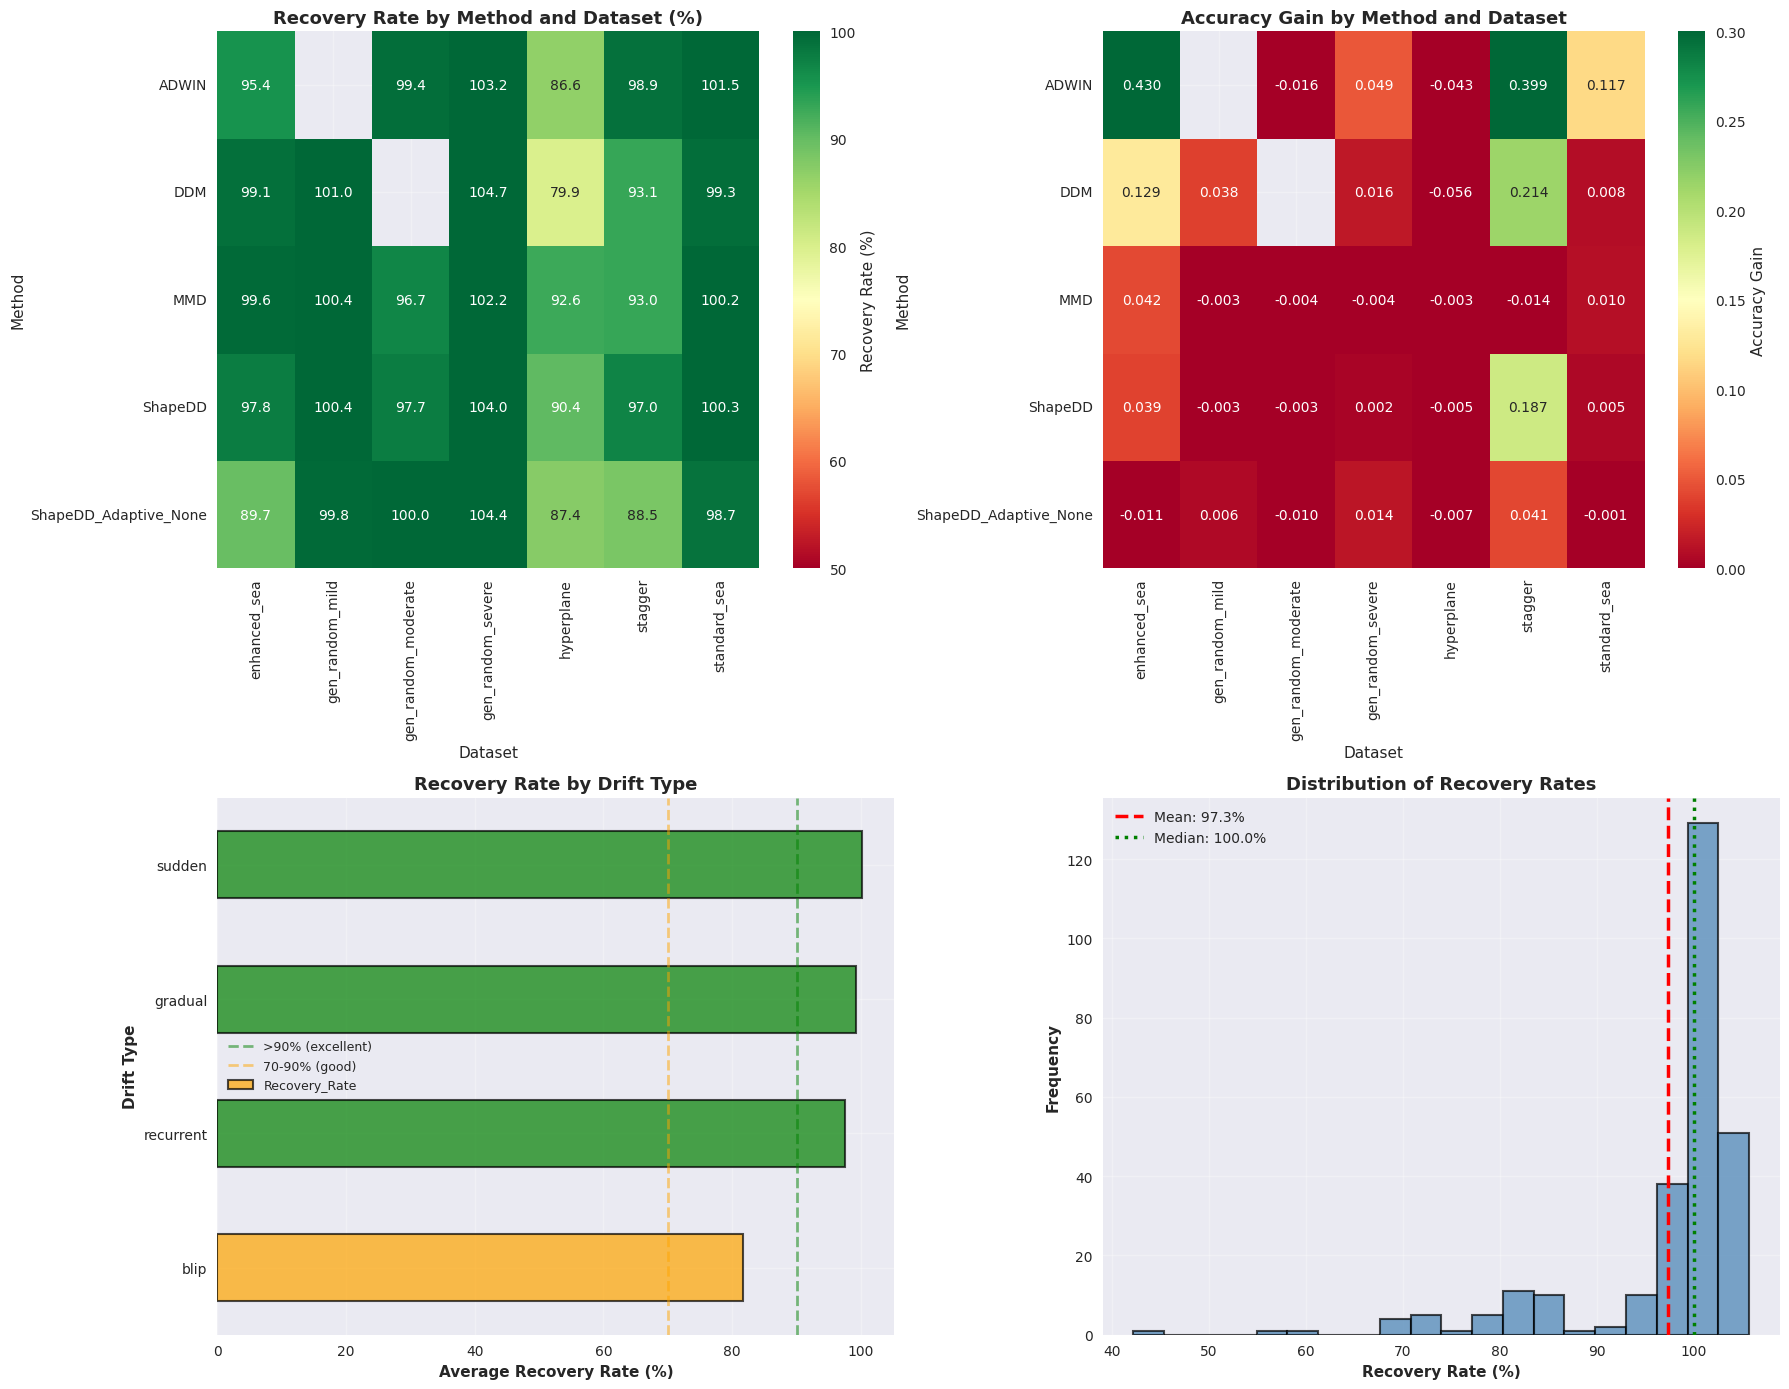


✓ Adaptation performance visualizations created
  Total adaptation events: 270
  Average recovery rate: 97.3%
  Average accuracy gain: 0.0248


In [11]:
# ============================================================================
# SECTION 9: VISUALIZATION - ADAPTATION PERFORMANCE HEATMAP
# ============================================================================

if len(all_results) == 0 or not results_df['Adaptation_Enabled'].iloc[0]:
    print("⚠ No adaptation results to visualize")
else:
    # Extract adaptation events
    adaptation_records = []
    for result in all_results:
        for event in result.get('adaptation_events', []):
            adaptation_records.append({
                'Method': result['method'],
                'Dataset': result['dataset'],
                'Drift_Type': event['drift_type'],
                'Recovery_Rate': event['recovery_rate'],
                'Acc_Gain': event['acc_gain']
            })

    if adaptation_records:
        adaptation_df = pd.DataFrame(adaptation_records)

        # Create visualizations
        fig, axes = plt.subplots(2, 2, figsize=(18, 14))

        # 1. Recovery rate by method and dataset
        ax = axes[0, 0]
        recovery_pivot = adaptation_df.pivot_table(values='Recovery_Rate',
                                                    index='Method', columns='Dataset',
                                                    aggfunc='mean')
        sns.heatmap(recovery_pivot, annot=True, fmt='.1f', cmap='RdYlGn',
                   vmin=50, vmax=100, cbar_kws={'label': 'Recovery Rate (%)'}, ax=ax)
        ax.set_title('Recovery Rate by Method and Dataset (%)', fontsize=13, fontweight='bold')

        # 2. Accuracy gain by method and dataset
        ax = axes[0, 1]
        gain_pivot = adaptation_df.pivot_table(values='Acc_Gain',
                                                index='Method', columns='Dataset',
                                                aggfunc='mean')
        sns.heatmap(gain_pivot, annot=True, fmt='.3f', cmap='RdYlGn',
                   vmin=0, vmax=0.3, cbar_kws={'label': 'Accuracy Gain'}, ax=ax)
        ax.set_title('Accuracy Gain by Method and Dataset', fontsize=13, fontweight='bold')

        # 3. Recovery rate by drift type
        ax = axes[1, 0]
        drift_type_recovery = adaptation_df.groupby('Drift_Type')['Recovery_Rate'].mean().sort_values()
        colors = ['green' if x >= 90 else 'orange' if x >= 70 else 'red' for x in drift_type_recovery.values]
        drift_type_recovery.plot(kind='barh', ax=ax, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
        ax.axvline(90, color='green', linestyle='--', linewidth=2, alpha=0.5, label='>90% (excellent)')
        ax.axvline(70, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='70-90% (good)')
        ax.set_xlabel('Average Recovery Rate (%)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Drift Type', fontsize=11, fontweight='bold')
        ax.set_title('Recovery Rate by Drift Type', fontsize=13, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(axis='x', alpha=0.3)

        # 4. Distribution of recovery rates
        ax = axes[1, 1]
        ax.hist(adaptation_df['Recovery_Rate'], bins=20, alpha=0.7, color='steelblue',
               edgecolor='black', linewidth=1.5)
        ax.axvline(adaptation_df['Recovery_Rate'].mean(), color='red', linestyle='--',
                  linewidth=2.5, label=f"Mean: {adaptation_df['Recovery_Rate'].mean():.1f}%")
        ax.axvline(adaptation_df['Recovery_Rate'].median(), color='green', linestyle=':',
                  linewidth=2.5, label=f"Median: {adaptation_df['Recovery_Rate'].median():.1f}%")
        ax.set_xlabel('Recovery Rate (%)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
        ax.set_title('Distribution of Recovery Rates', fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(f"\n✓ Adaptation performance visualizations created")
        print(f"  Total adaptation events: {len(adaptation_df)}")
        print(f"  Average recovery rate: {adaptation_df['Recovery_Rate'].mean():.1f}%")
        print(f"  Average accuracy gain: {adaptation_df['Acc_Gain'].mean():.4f}")


In [12]:
# ============================================================================
# SECTION 10: KEY FINDINGS AND INSIGHTS
# ============================================================================

if len(all_results) == 0:
    print("⚠ No results available")
else:
    print("\n" + "="*80)
    print("KEY FINDINGS - INTEGRATED DRIFT DETECTION + ADAPTATION")
    print("="*80)

    # Detection findings
    print("\n1. DETECTION PERFORMANCE:")
    best_detector = results_df.loc[results_df['F1'].idxmax()]
    print(f"   - Best detector: {best_detector['Method']} (F1={best_detector['F1']:.3f})")
    print(f"   - Average F1 across all methods: {results_df['F1'].mean():.3f}")
    print(f"   - Average detection rate: {results_df['Detection_Rate'].mean():.1%}")
    avg_mttd = results_df['MTTD'].mean()
    if not np.isnan(avg_mttd):
        print(f"   - Average MTTD: {avg_mttd:.1f} samples")

    # Adaptation findings (if enabled)
    if results_df['Adaptation_Enabled'].iloc[0]:
        adaptation_records = []
        for result in all_results:
            for event in result.get('adaptation_events', []):
                adaptation_records.append({
                    'method': result['method'],
                    'drift_type': event['drift_type'],
                    'recovery_rate': event['recovery_rate'],
                    'acc_gain': event['acc_gain']
                })

        if adaptation_records:
            adaptation_df = pd.DataFrame(adaptation_records)

            print("\n2. ADAPTATION PERFORMANCE:")
            print(f"   - Total adaptation events: {len(adaptation_df)}")
            print(f"   - Average recovery rate: {adaptation_df['recovery_rate'].mean():.1f}%")
            print(f"   - Average accuracy gain: {adaptation_df['acc_gain'].mean():.4f}")

            # Success rate by recovery threshold
            excellent = (adaptation_df['recovery_rate'] >= 90).sum()
            good = ((adaptation_df['recovery_rate'] >= 70) & (adaptation_df['recovery_rate'] < 90)).sum()
            poor = (adaptation_df['recovery_rate'] < 70).sum()

            print(f"\n   Recovery quality breakdown:")
            print(f"   - Excellent (≥90%): {excellent}/{len(adaptation_df)} ({excellent/len(adaptation_df)*100:.1f}%)")
            print(f"   - Good (70-90%): {good}/{len(adaptation_df)} ({good/len(adaptation_df)*100:.1f}%)")
            print(f"   - Poor (<70%): {poor}/{len(adaptation_df)} ({poor/len(adaptation_df)*100:.1f}%)")

            # Best drift type for adaptation
            best_drift_type = adaptation_df.groupby('drift_type')['recovery_rate'].mean().idxmax()
            best_drift_recovery = adaptation_df.groupby('drift_type')['recovery_rate'].mean().max()
            print(f"\n   - Best adapted drift type: {best_drift_type} ({best_drift_recovery:.1f}% recovery)")

            # Best method for adaptation
            best_adapt_method = adaptation_df.groupby('method')['recovery_rate'].mean().idxmax()
            best_adapt_recovery = adaptation_df.groupby('method')['recovery_rate'].mean().max()
            print(f"   - Best method for adaptation: {best_adapt_method} ({best_adapt_recovery:.1f}% recovery)")

    print("\n" + "="*80)
    print("CONCLUSION:")
    print("="*80)
    if results_df['Adaptation_Enabled'].iloc[0] and adaptation_records:
        print("This integrated approach demonstrates that:")
        print("1. Drift detection identifies concept drift in real-time")
        print("2. Drift type classification guides adaptation strategy selection")
        print("3. Matched adaptation strategies improve model recovery after drift")
        print(f"4. Average recovery rate of {adaptation_df['recovery_rate'].mean():.1f}% validates the approach")
    else:
        print("Detection-only mode completed successfully.")
        print("Set ENABLE_ADAPTATION=True in Cell 6 to test integrated flow.")
    print("="*80)



KEY FINDINGS - INTEGRATED DRIFT DETECTION + ADAPTATION

1. DETECTION PERFORMANCE:
   - Best detector: ADWIN (F1=1.000)
   - Average F1 across all methods: 0.324
   - Average detection rate: 67.6%
   - Average MTTD: 86.2 samples

2. ADAPTATION PERFORMANCE:
   - Total adaptation events: 270
   - Average recovery rate: 97.3%
   - Average accuracy gain: 0.0248

   Recovery quality breakdown:
   - Excellent (≥90%): 230/270 (85.2%)
   - Good (70-90%): 34/270 (12.6%)
   - Poor (<70%): 6/270 (2.2%)

   - Best adapted drift type: sudden (100.2% recovery)
   - Best method for adaptation: DDM (99.3% recovery)

CONCLUSION:
This integrated approach demonstrates that:
1. Drift detection identifies concept drift in real-time
2. Drift type classification guides adaptation strategy selection
3. Matched adaptation strategies improve model recovery after drift
4. Average recovery rate of 97.3% validates the approach
